This project demonstrates the step-by-step process of finding the best model that can be utilized to recommend a medication based on condition, symptom and other demographic 
information for a patient. The dataset used to perform this analysis is sourced from https://www.kaggle.com/datasets/asjad99/mimiciii/data, the data is further grouped and synthetic data is added to create a reasonable pool of records to analyze and train a model.

MIMIC-III (Medical Information Mart for Intensive Care) is a freely accessible database developed by the MIT Lab for Computational Physiology. It contains detailed information about over 60,000 ICU admissions to Beth Israel Deaconess Medical Center between 2001 and 2012. For this analysis, the data is derived from Patient, Prescriptions, Admissions , ICD and Drug code datasets.

Building and implementing a predictive model for medication recommendation in an EHR system will enable providers to make informed medication decisions and
will prove to be a useful tool to study medication effectiveness and additionally will help minimize hospitalization and provider visits.

Disclaimer:This project is a preliminary effort to predict with a limited dataset and is would need additional preprocessing for larger datasets or neural network based models to integrate with an EHR system.

The dataset includes following columns derived from MIMIC-III along with synthetic data augmented:

Columns	                         -         Description                                           
PatientID	                     -        Incremental value masked                                          
Age	                             -        Age                                          
Gender	                         -        Gender M/F                                          
BMI	                             -        Body Mass Index                                          
Weight_kg	                     -        Weight                                          
Height_cm	                     -        Height                                          
Chronic_
Conditions	                     -        Existing condition                                          
Symptoms	                     -        Symptoms                                          
Diagnosis	                     -        Diagnosis code                                          
Recommended_
Medication	                     -        Medication prescribed for existing condition/symptom                                         
NDC	                             -        National Drug Code                                          
Dosage	                         -        Medication Dosage                                          
Duration	                     -        Duration for Medication                                          
Treatmen_
Effectiveness	                 -        Effectiveness of Medication                                          
Adverse_
Reactions	                     -        Any allergic reactions or side-effects                                          
Recovery_
Time_Days	                     -        Recovery time average    


In [254]:
#Libraries used
import random
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree
import time
import random

#preprocessing and metrics
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV,cross_validate
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder,MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,precision_score
from sklearn.metrics import recall_score,f1_score,ConfusionMatrixDisplay,mean_squared_error,r2_score,make_scorer
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import shap
#implementation
import joblib

## Data Preprocessing and Analysis
The dataset is loaded into a Pandas DataFrame. The CSV file contains the following:

1.Features related to patient demographics, symptom ,conditions                                              
2.Target variable indicating the recommended medication
 
The first few rows are analyzed to understand its structure and content.

 ### 1. Load Data

In [287]:

df = pd.read_csv("data/patient_icd_rx_grouped.csv")
df.sample(10)

,PatientID,Age,Gender,BMI,Weight_kg,Height_cm,Chronic_Conditions,Symptoms,Diagnosis,Recommended_Medication,NDC,Dosage,Duration,Treatment_Effectiveness,Adverse_Reactions,Recovery_Time_Days
7363,10525,89,F,32.8,95.0,170.2,symptomatic bradycardia,Cardiogenic shock,78551,NaN,5.817700e+10,10mEq ER,7 days,High,NaN,5
4505,6469,56,M,24.5,72.1,171.6,thoracic abdominal aneurysm,Obstruction of bile duct,5762,Multivitamin Iv,6.659102e+10,10mL Vial,7 days,Low,NaN,15
5593,8059,80,F,21.3,57.8,164.7,newborn,NB obsrv suspct infect,V290,NaN,7.466530e+07,2mEq/ml-20ml,14 days,High,NaN,5
5509,7938,58,M,19.0,55.7,171.0,left chest wall wound,Open wound of axilla,88002,Acetaminophen,4.505013e+07,325MG TAB,7 days,Moderate,NaN,10
3483,5013,85,M,35.0,85.7,156.5,chest pain\cardiac cath,Crnry athrscl natve vssl,41401,Meperidine,4.091178e+08,50mg Syringe,5 days,High,NaN,5
6665,9580,79,M,26.7,83.5,176.7,gastrointestinal bleed,Thrombocytopenia NOS,2875,NaN,0.000000e+00,100ml Bag,10 days,Low,NaN,15
744,1065,82,F,28.6,80.1,167.4,newborn,Need prphyl vc vrl hepat,V053,NaN,5.172930e+08,23.4%;30mL Vial,7 days,High,Rash,5
6777,9736,69,M,22.9,52.0,150.7,post operative bleeding,Ac posthemorrhag anemia,2851,Furosemide,5.175710e+08,100mg/10mL Vial,14 days,High,Nausea,5
5305,7624,36,F,35.1,103.9,172.0,headache;fever;?meningitis,Osteomyelit NOS-oth site,73028,NaN,3.380049e+08,1000mL Bag,14 days,High,NaN,5
3842,5539,88,F,25.9,73.8,168.8,newborn,Single lb in-hosp w/o cs,V3000,Neoivampicillin,6.332304e+10,500mg Vial,7 days,High,Nausea,5


### 2. Exploratory Data Analysis (EDA)

EDA is a crucial step to understand the dataset and identify potential issues. Here, we:            

  1. Check for missing values in each column using value counts.                 
  2. Summarize numerical features using descriptive statistics and histograms           
  3. Summarize categorical features                   
  4. Identify outliers for numeric datatypes                 
  5. Find correlation between features using heatmap                  
  6. Visualize categorical feature distribution against top 10 values for target variable (Recommended_Medication)              
  7. Visualize the top 10 distribution of the target variable (Recommended_Medication) 

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7394 entries, 0 to 7393
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PatientID                7394 non-null   int64  
 1   Age                      7394 non-null   int64  
 2   Gender                   7394 non-null   object 
 3   BMI                      7394 non-null   float64
 4   Weight_kg                7394 non-null   float64
 5   Height_cm                7394 non-null   float64
 6   Chronic_Conditions       7394 non-null   object 
 7   Symptoms                 7394 non-null   object 
 8   Diagnosis                7394 non-null   object 
 9   Recommended_Medication   5842 non-null   object 
 10  NDC                      7387 non-null   float64
 11  Dosage                   7394 non-null   object 
 12  Duration                 7394 non-null   object 
 13  Treatment_Effectiveness  7394 non-null   object 
 14  Adverse_Reactions       

In [7]:
print(df.isnull().sum())

PatientID                     0
Age                           0
Gender                        0
BMI                           0
Weight_kg                     0
Height_cm                     0
Chronic_Conditions            0
Symptoms                      0
Diagnosis                     0
Recommended_Medication     1552
NDC                           7
Dosage                        0
Duration                      0
Treatment_Effectiveness       0
Adverse_Reactions          3774
Recovery_Time_Days            0
dtype: int64


In [8]:
for col in df.columns:
    print(f"value counts for column '{col}':")
    print(df[col].value_counts(dropna=False))

value counts for column 'PatientID':
PatientID
2        1
7097     1
7095     1
7094     1
7093     1
        ..
3555     1
3554     1
3553     1
3551     1
10566    1
Name: count, Length: 7394, dtype: int64
value counts for column 'Age':
Age
20    131
38    126
69    125
64    123
61    121
     ... 
74     82
21     81
39     81
50     75
60     74
Name: count, Length: 72, dtype: int64
value counts for column 'Gender':
Gender
M    4161
F    3233
Name: count, dtype: int64
value counts for column 'BMI':
BMI
24.1    67
23.7    63
26.5    62
24.5    61
22.8    57
        ..
48.4     1
10.1     1
39.8     1
8.3      1
39.0     1
Name: count, Length: 359, dtype: int64
value counts for column 'Weight_kg':
Weight_kg
71.1     31
71.9     31
72.8     28
68.2     28
70.7     28
         ..
39.2      1
109.3     1
107.5     1
102.4     1
26.8      1
Name: count, Length: 778, dtype: int64
value counts for column 'Height_cm':
Height_cm
175.8    41
169.2    39
171.2    38
169.8    37
168.3    37
  

In [9]:
df.describe()

,PatientID,Age,BMI,Weight_kg,Height_cm,NDC,Recovery_Time_Days
count,7394.000000,7394.000000,7394.000000,7394.000000,7394.000000,7.387000e+03,7394.000000
mean,5315.057750,53.693941,24.540736,70.239816,170.072681,1.191677e+10,7.489857
std,3063.108832,20.849238,6.031494,14.947139,9.885183,2.287263e+10,3.350884
min,2.000000,18.000000,6.700000,20.600000,133.800000,0.000000e+00,5.000000
25%,2651.250000,36.000000,20.300000,60.100000,163.500000,4.662876e+07,5.000000
50%,5339.500000,54.000000,24.300000,70.500000,170.150000,3.100300e+08,5.000000
75%,7982.750000,72.000000,28.500000,80.500000,176.600000,7.031153e+08,10.000000
max,10566.000000,89.000000,55.500000,129.300000,207.000000,8.770108e+10,15.000000


In [10]:
df.describe(include=['object'])

,Gender,Chronic_Conditions,Symptoms,Diagnosis,Recommended_Medication,Dosage,Duration,Treatment_Effectiveness,Adverse_Reactions
count,7394,7394,7394,7394,5842,7394,7394,7394,3620
unique,2,2911,1497,1500,545,854,4,3,3
top,M,newborn,Hypertension NOS,4019,Metoprolol,250mL Bag,5 days,High,Nausea
freq,4161,1164,321,321,208,210,1904,4448,1450


##### Identify outliers for numeric datatypes

In [12]:
df_numeric = df.select_dtypes(include=['int64','float64'])
Q1 = df_numeric.quantile(0.25)
Q2 = df_numeric.quantile(0.75)
IQR = Q2 - Q1
#range for non-outlier data
lb = Q1 - 1.5 * IQR
ub = Q2 + 1.5 * IQR

#identify outliers
out_mask = ((df_numeric < lb) | (df_numeric > ub)).any(axis=1)
df_out = df[out_mask]

print(f"Original dataset size: {df.shape[0]}")
print(f"Dataset size after removing outliers: {df_out.shape[0]}")


Original dataset size: 7394
Dataset size after removing outliers: 1791


##### Detecting outliers resulted in a smaller dataset that would be insufficient for training and testing models.Hence using original dataset.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7394 entries, 0 to 7393
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PatientID                7394 non-null   int64  
 1   Age                      7394 non-null   int64  
 2   Gender                   7394 non-null   object 
 3   BMI                      7394 non-null   float64
 4   Weight_kg                7394 non-null   float64
 5   Height_cm                7394 non-null   float64
 6   Chronic_Conditions       7394 non-null   object 
 7   Symptoms                 7394 non-null   object 
 8   Diagnosis                7394 non-null   object 
 9   Recommended_Medication   5842 non-null   object 
 10  NDC                      7387 non-null   float64
 11  Dosage                   7394 non-null   object 
 12  Duration                 7394 non-null   object 
 13  Treatment_Effectiveness  7394 non-null   object 
 14  Adverse_Reactions       

##### correlation between features

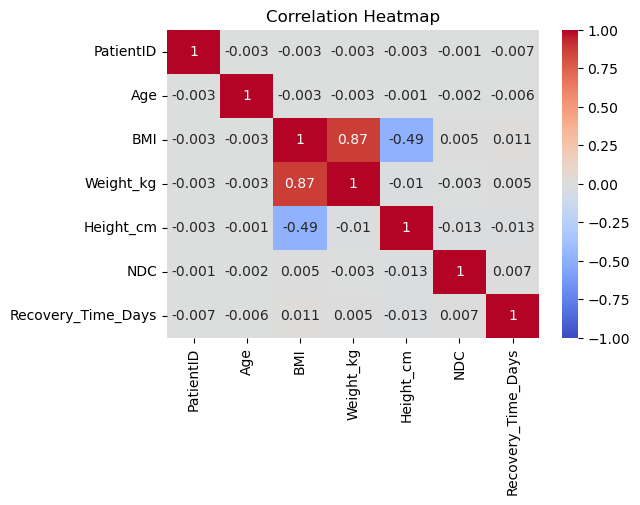

In [16]:
df_numeric = df.select_dtypes(include=['int64','float64'])
plt.figure(figsize = (6,4))
sns.heatmap(df_numeric.corr().round(3),annot=True,cmap='coolwarm',vmin=-1,vmax=1)
plt.title('Correlation Heatmap')
plt.show()

#### Insights from correlation heatmap for numerical features
 * weight and BMI have a positive correlation indicating weight of the patient can be a cause for certain chronic conditions
 * other features indicate negative correlation showing no multicollinearity

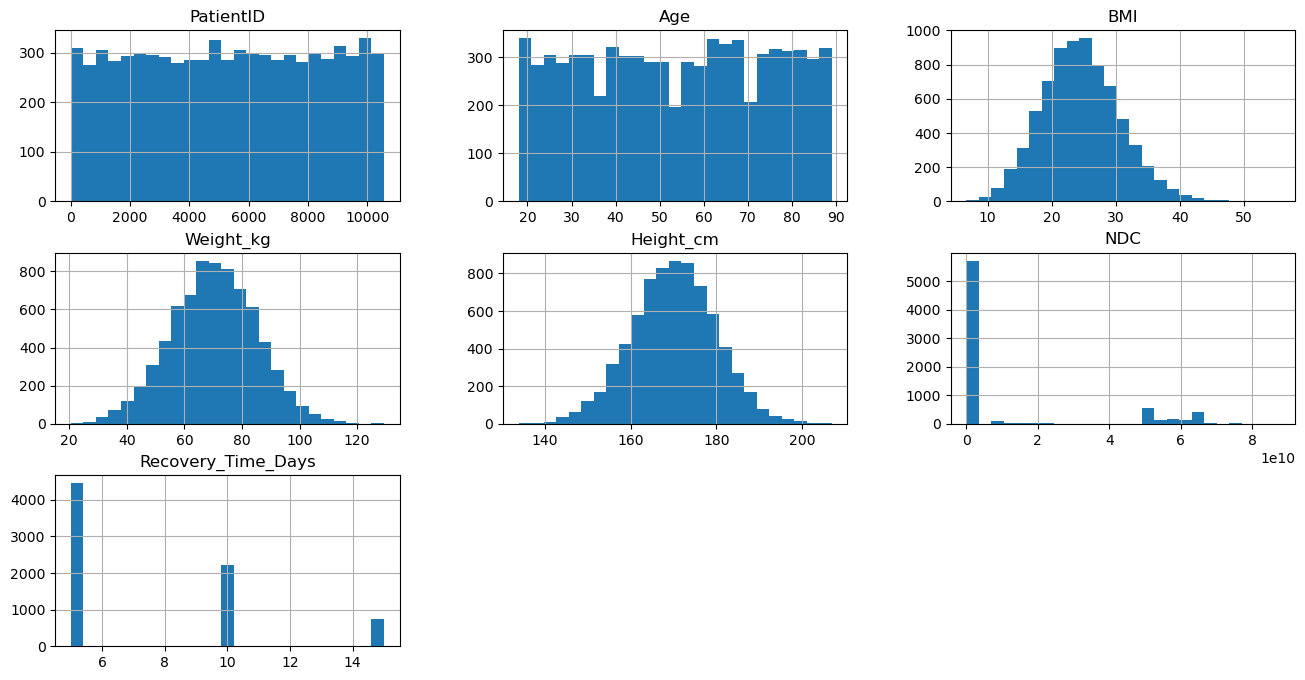

In [17]:
df_numeric.hist(bins=25,figsize=(16,8))
plt.show()

##### Analyze categorical columns 

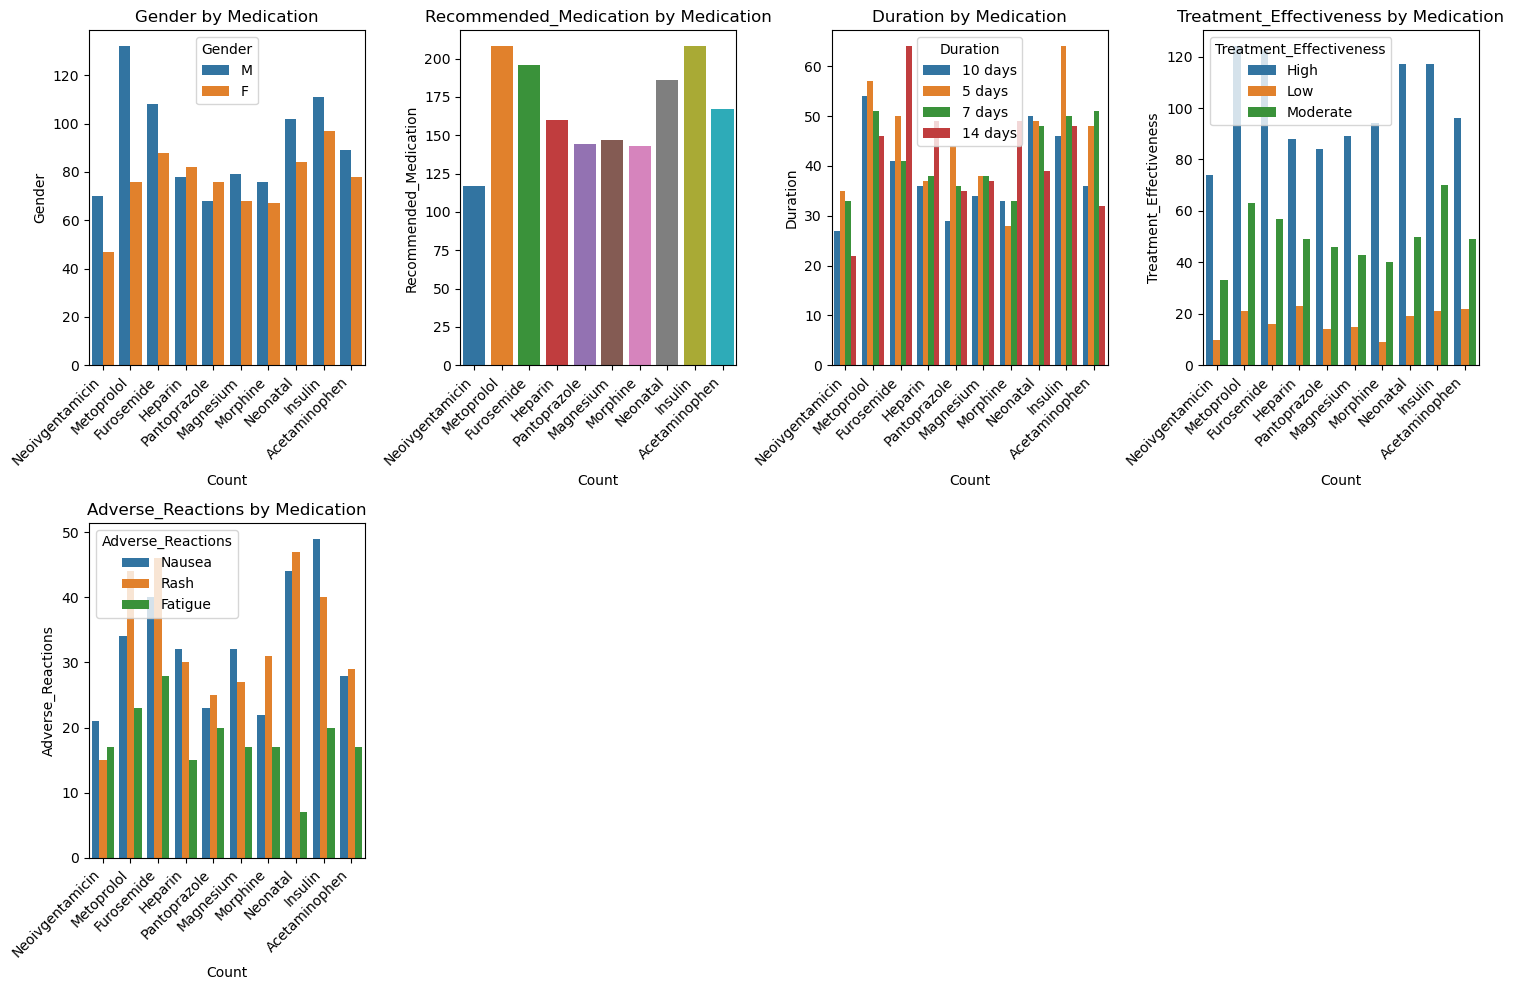

In [18]:
df_category=df.select_dtypes(include=['object']).applymap(lambda x: ', '.join(x) if isinstance(x, list) else x)

df_exploded = df_category.explode('Symptoms')
df_exploded['Symptoms'] = df_exploded['Symptoms'].astype(str)
df_exploded = df_exploded.applymap(lambda x: ', '.join(x) if isinstance(x, list) else x)

top_meds = df_exploded['Recommended_Medication'].value_counts().index[:10]
df_top = df_exploded[df_exploded['Recommended_Medication'].isin(top_meds)].copy()

top_5_cat_cols = [col for col in df_top.select_dtypes(include=['object']).columns if 2 <= df_top[col].nunique() <= 10][:5]


fig, axes = plt.subplots(2, 4, figsize=(15, 10),squeeze=True)
axes = axes.flatten()
for i, col in enumerate(top_5_cat_cols):
    sns.countplot(data=df_top, x='Recommended_Medication',hue=col, ax=axes[i])
    axes[i].set_title(f"{col} by Medication")
    axes[i].set_xlabel("Count")
    axes[i].set_ylabel(col)
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')
    plt.legend(bbox_to_anchor=(3, 1), loc='upper right')
# Remove unused axes
for j in range(len(top_5_cat_cols), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

##### Plot count of top 50 medications

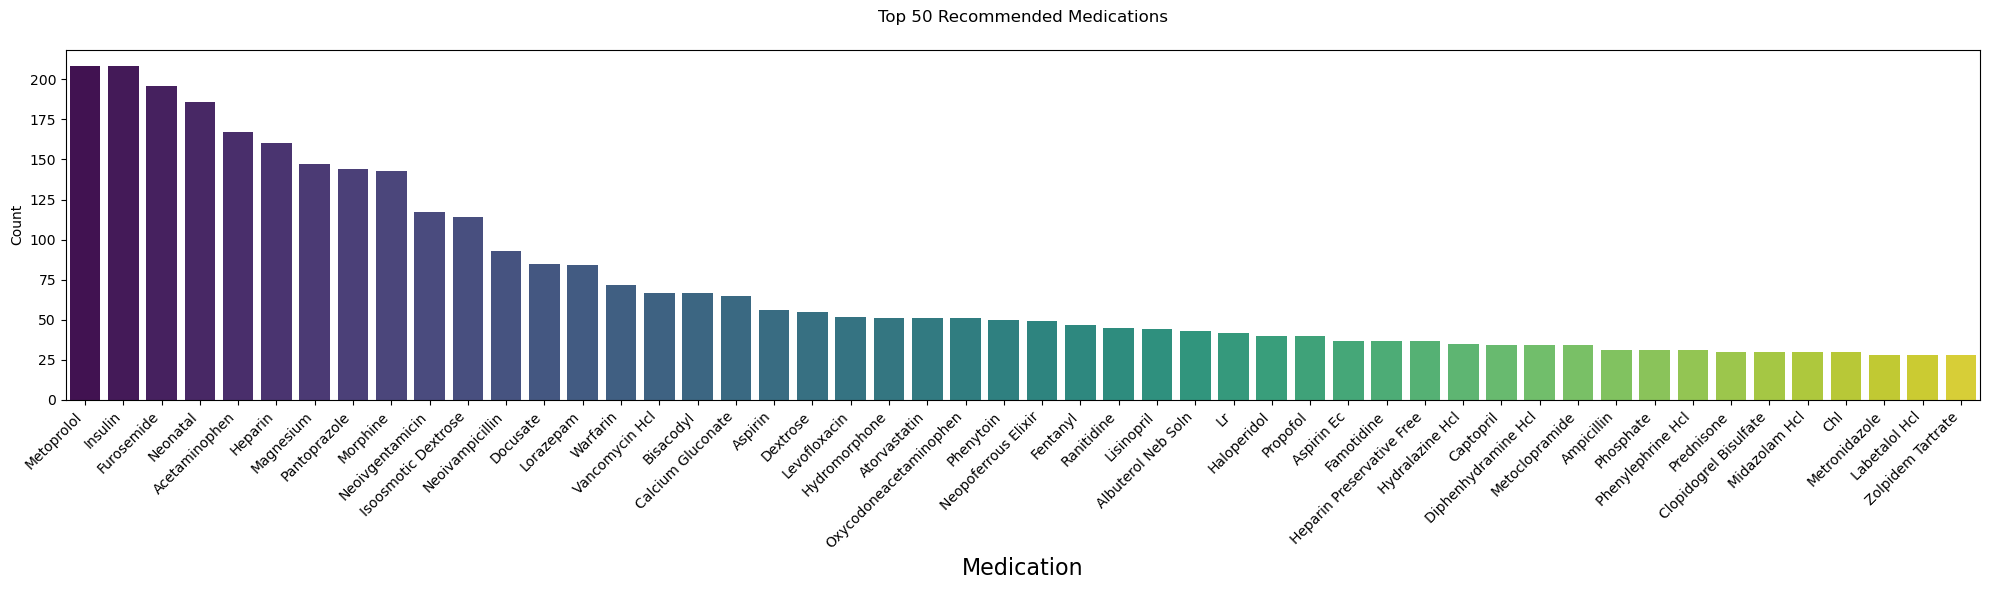

In [144]:
top_meds_counts = df['Recommended_Medication'].value_counts().nlargest(50)
plt.figure(figsize=(20, 6))
sns.barplot(x=top_meds_counts.index, y=top_meds_counts.values, palette="viridis")

plt.xticks(rotation=45, ha='right')
plt.title("Top 50 Recommended Medications", pad=20)
plt.xlabel("Medication",fontsize=16)
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### Data cleanup 

* Patient id column is dropped since its an id column and not relevant for prediction.                              
* The current model is aiming to build recommended medication based on condition, symptom and diagnosis code.                        
* Adverse_Reactions,Treatment_Effectiveness, Recover_Time_Days,Duration are considered as post treatment outcomes, and are dropped for current prediction.              


In [20]:
df = df.drop(['PatientID', 'Adverse_Reactions','Dosage','Treatment_Effectiveness','Recovery_Time_Days','Duration'],axis=1)
df = df.dropna(subset=['Recommended_Medication'])

### 3. Feature Engineering


Preprocessing is essential to prepare the data for model training. The steps include:

  Separating features (X) and the target variable (y).
  Identifying categorical and numerical columns.
  Creating pipelines for:             
    * Numerical Features: Imputing missing values and scaling (Age, BMI, Height, Weight)         
    * Categorical Features : Imputing missing values and one-hot encoding (Gender,Diagnosis)           
    * Text Features: Separately use TFIDFVectorizer to convert split text colums Chronic_Conditions and Symptoms          
Combining these transformations into a unified preprocessing pipeline.

#### convert text in symptom and chronic condition columns using Tfidfvectorizer

In [24]:
def prepare_text_column(column):
    def normalize(x):
        if isinstance(x, list):
            return ' '.join(str(i) for i in x)
        elif isinstance(x, str):
            return x
        else:
            return ''
    return column.fillna('').apply(normalize)

In [34]:
#Feature Extraction :convert text in symptom and chronic condition columns using TFidvectorizer
df['Symptoms_clean'] = prepare_text_column(df['Symptoms'])
df['Chronic_Conditions_clean'] = prepare_text_column(df['Chronic_Conditions'])

# Vectorize Symptoms
symptom_vectorizer = TfidfVectorizer(binary=True, stop_words='english', max_features=100)
symptom_encoded = symptom_vectorizer.fit_transform(df['Symptoms_clean'])

# Save symptom vectorizer
joblib.dump(symptom_vectorizer, 'symptom_vectorizer.pkl')

# Vectorize Chronic Conditions
chronic_vectorizer = TfidfVectorizer(binary=True, stop_words='english', max_features=100)
chronic_encoded = chronic_vectorizer.fit_transform(df['Chronic_Conditions_clean'])

# Save chronic condition vectorizer
joblib.dump(chronic_vectorizer, 'chronic_vectorizer.pkl')

# Convert to DataFrame
symptom_df = pd.DataFrame(symptom_encoded.toarray(), columns=[f"Symptom_{w}" for w in symptom_vectorizer.get_feature_names_out()])
chronic_df = pd.DataFrame(chronic_encoded.toarray(), columns=[f"Chronic_{w}" for w in chronic_vectorizer.get_feature_names_out()])

# Combine with original DataFrame
df_final = pd.concat([df, symptom_df, chronic_df], axis=1)



In [36]:
#drop rows with NaN values
df_final = df_final.dropna(axis=0)


In [38]:
df_final

,Age,Gender,BMI,Weight_kg,Height_cm,Chronic_Conditions,Symptoms,Diagnosis,Recommended_Medication,NDC,...,Chronic_subarachnoid,Chronic_subdural,Chronic_syndrome,Chronic_telemetry,Chronic_trauma,Chronic_unstable,Chronic_upper,Chronic_valve,Chronic_vehicle,Chronic_wound
0,23.0,M,17.9,43.6,156.0,newborn,Single lb in-hosp w cs,V3001,Neoivgentamicin,6.332302e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,37.0,F,25.4,68.0,163.5,"fever,dehydration,failure to thrive",Adv eff antiviral drugs,E9317,Guaifenesincodeine Phosphate,3.186741e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,54.0,F,32.3,87.4,164.4,chronic renal failure/sda,Hyp kid NOS w cr kid V,40391,Pamidronate,8.326010e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,77.0,M,26.6,82.7,176.3,newborn,Need prphyl vc vrl hepat,V053,Neoivgentamicin,6.410394e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,34.0,M,29.0,82.5,168.8,hemorrhagic cva,Intracerebral hemorrhage,431,Nasal,2.560152e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5837,74.0,F,19.0,61.0,179.1,newborn,NB obsrv suspct infect,V290,Neopoferrous Elixir,1.821382e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5838,44.0,F,16.2,36.9,150.9,brain;chest and liver mass,Obstructiv hydrocephalus,3314,Insulin,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5839,43.0,F,24.8,84.3,184.3,s/p motor vehicle accident,Coma,78001,Desmopressin Acetate,7.524510e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5840,64.0,M,23.9,53.0,148.9,newborn,Single lb in-hosp w cs,V3001,Desitin,7.430000e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
#Feature Engineering: define Encoding and impute pipeline 
ONEHOT_FEATURES = ['Gender','Diagnosis']

NUMERICAL_FEATURES = ['Age','Weight_kg','Height_cm','BMI']

#Creating a preprocessor

numeric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

onehot_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent', fill_value='missing')),
     ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
   
])

#preprocessor
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, NUMERICAL_FEATURES),
        ('cat', onehot_transformer, ONEHOT_FEATURES)

    ]
)
label_encoder = LabelEncoder()
df_final['NDC_encoded'] = label_encoder.fit_transform(df_final['NDC'])

In [42]:
FEATURES = NUMERICAL_FEATURES + ONEHOT_FEATURES+['NDC_encoded']+symptom_df.columns.tolist()+chronic_df.columns.tolist()
df_final[FEATURES]

,Age,Weight_kg,Height_cm,BMI,Gender,Diagnosis,NDC_encoded,Symptom_abn,Symptom_ac,Symptom_acute,...,Chronic_subarachnoid,Chronic_subdural,Chronic_syndrome,Chronic_telemetry,Chronic_trauma,Chronic_unstable,Chronic_upper,Chronic_valve,Chronic_vehicle,Chronic_wound
0,23.0,43.6,156.0,17.9,M,V3001,862,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,37.0,68.0,163.5,25.4,F,E9317,107,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,54.0,87.4,164.4,32.3,F,40391,304,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,77.0,82.7,176.3,26.6,M,V053,569,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,34.0,82.5,168.8,29.0,M,431,422,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5837,74.0,61.0,179.1,19.0,F,V290,396,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5838,44.0,36.9,150.9,16.2,F,3314,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5839,43.0,84.3,184.3,24.8,F,78001,290,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5840,64.0,53.0,148.9,23.9,M,V3001,897,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
class_counts = df_final['Recommended_Medication'].value_counts()
class_counts


Recommended_Medication
Insulin                            166
Furosemide                         166
Metoprolol                         156
Neonatal                           142
Acetaminophen                      133
                                  ... 
Amaryl                               1
Dextran                              1
Morphine Concentrated Oral Soln      1
Stavudine                            1
Magnesium Replacement Oncology       1
Name: count, Length: 508, dtype: int64

In [46]:
# Count the number of samples per class
class_counts = df_final['Recommended_Medication'].value_counts()

# Keep only classes with at least 2 samples
valid_classes = class_counts[class_counts > 20].index
df_filtered = df_final[df_final['Recommended_Medication'].isin(valid_classes)]
df_filtered

FEATURES = NUMERICAL_FEATURES + ONEHOT_FEATURES+['NDC_encoded']+symptom_df.columns.tolist()+chronic_df.columns.tolist()
X = df_filtered[FEATURES]

df_filtered['Recommended_Medication']= df_filtered['Recommended_Medication'].astype(str)
df_filtered['Recommended_Medication_list'] = df_filtered['Recommended_Medication'].apply(lambda x: [med.strip() for med in x.split(',')])
y = df_filtered['Recommended_Medication_list']

### 3. Split Train and Test set

##### Splitting dataset is crucial to evaluate model generalization by ensuring that the model learns from a training set and is tested on a separate unseen test set, preventing overfitting and providing a reliable measure of performance on new data.


In [49]:
#split to train/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

print(f"Training set size: {X_train.shape}. Training labels size: {y_train.shape}")
print(f"Test set size: {X_test.shape}. Test labels size: {y_test.shape}")


Training set size: (1859, 207). Training labels size: (1859,)
Test set size: (1001, 207). Test labels size: (1001,)


##### The target variable represents multilabels per observation, using multilabelbinarizer for target variable, below plot indicates top 15 medication labels distribution across train and test sets

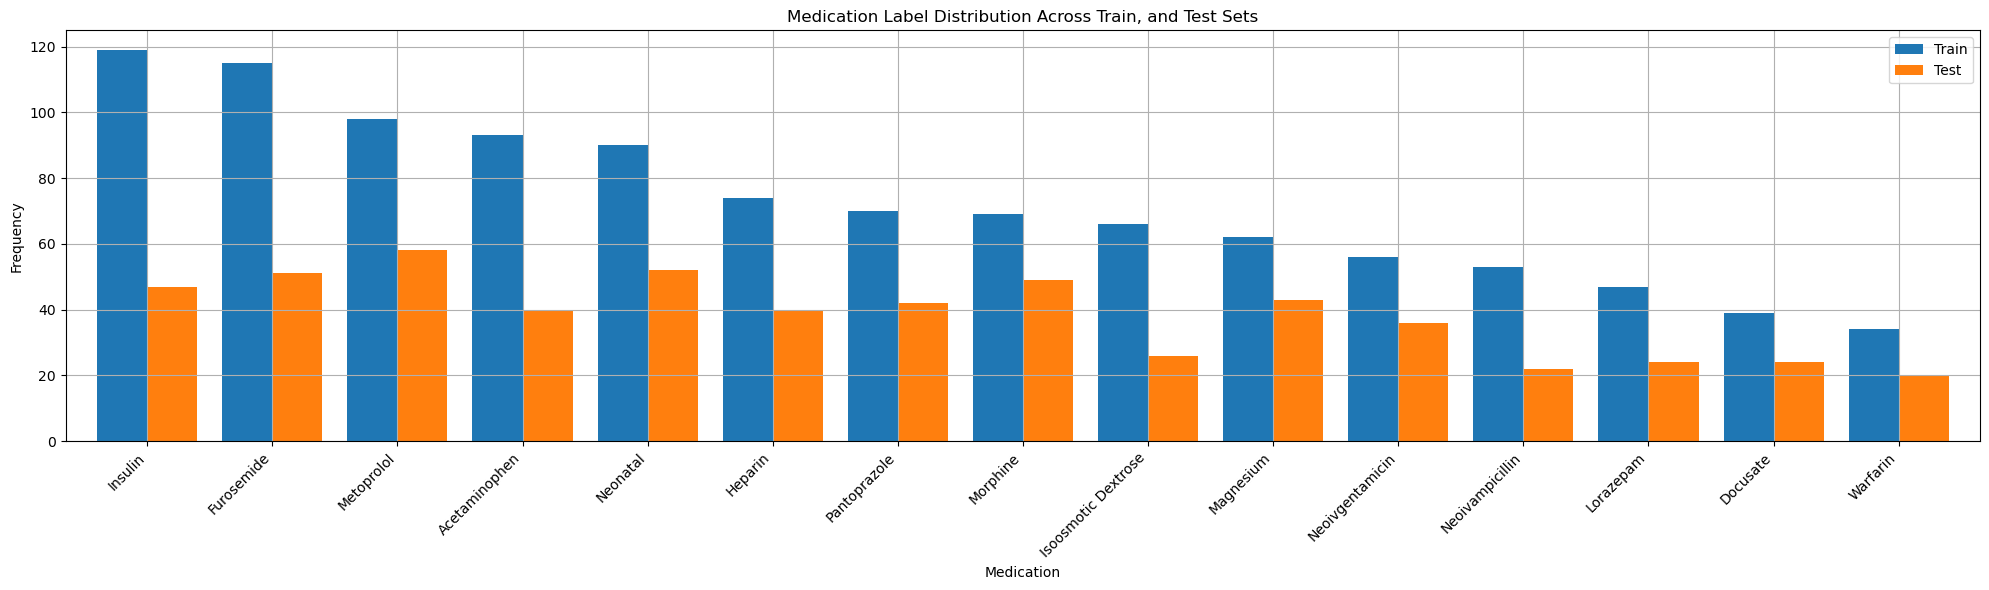

In [51]:
#Medication distribution between train and test set
mlb = MultiLabelBinarizer()

y_train_encoded = mlb.fit_transform(y_train)
y_test_encoded = mlb.transform(y_test)

#save Multilable binarizer
joblib.dump(mlb, 'label_binarizer.pkl')

y_train_df = pd.DataFrame(y_train_encoded,columns=mlb.classes_)
y_test_df = pd.DataFrame(y_test_encoded,columns=mlb.classes_)

# Step 2: Get label frequencies (i.e., how often each medication appears)

train_dist = y_train_df.sum()
test_dist = y_test_df.sum()

top_n = 15
top_medications = train_dist.sort_values(ascending=False).head(top_n).index.tolist()

# Step 4: Slice the top meds

train_top = train_dist[top_medications]
test_top = test_dist[top_medications]

# Step 5: Combine for plotting
distribution_df = pd.DataFrame({
    'Train': train_top,
    'Test': test_top
})

# Step 4: Plot
distribution_df.plot(kind='bar', figsize=(20, 6), width=0.8)
plt.title("Medication Label Distribution Across Train, and Test Sets")
plt.xlabel("Medication")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()

In [53]:
#Preprocess all features , since symptom and chronic conditions have been vectorized,
#these columns are included post preprocessing other columns
CORE_FEATURES = NUMERICAL_FEATURES + ONEHOT_FEATURES
SYMPTOM_FEATURES = symptom_df.columns.tolist()
CHRONIC_FEATURES = chronic_df.columns.tolist()
NDC_FEATURE = ['NDC_encoded']

X_train_core = preprocessor.fit_transform(X_train[CORE_FEATURES])
X_test_core = preprocessor.transform(X_test[CORE_FEATURES])

X_train_cc = X_train[SYMPTOM_FEATURES + CHRONIC_FEATURES+NDC_FEATURE].values
X_test_cc = X_test[SYMPTOM_FEATURES + CHRONIC_FEATURES+NDC_FEATURE].values

X_train_final = np.concatenate([X_train_core, X_train_cc], axis=1)
X_test_final = np.concatenate([X_test_core, X_test_cc], axis=1)

numerical_column_names = NUMERICAL_FEATURES


# The method get_feature_names_out generates the names of the new columns created by OneHotEncoder for the categorical columns
onehot_column_names = preprocessor.named_transformers_['cat'].get_feature_names_out(ONEHOT_FEATURES)

# Combine the names of numerical and all other feature columns into a single list
all_column_names = list(numerical_column_names) +list(onehot_column_names)+NDC_FEATURE+SYMPTOM_FEATURES+CHRONIC_FEATURES



In [55]:
X_train_final_df = pd.DataFrame(X_train_final, columns=all_column_names)
X_train_final_df

,Age,Weight_kg,Height_cm,BMI,Gender_F,Gender_M,Diagnosis_00845,Diagnosis_0090,Diagnosis_0380,Diagnosis_03811,...,Chronic_subarachnoid,Chronic_subdural,Chronic_syndrome,Chronic_telemetry,Chronic_trauma,Chronic_unstable,Chronic_upper,Chronic_valve,Chronic_vehicle,Chronic_wound
0,0.926046,-0.626190,1.392215,-1.063468,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,120.0
1,-0.670148,0.049145,0.368290,-0.160764,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,596.0
2,1.216263,1.275238,1.584835,0.242229,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,91.0
3,-0.428301,-0.291801,-2.044524,0.741940,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,174.0
4,0.200503,1.760430,3.176481,-0.096285,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.576102,0.0,0.0,0.0,0.0,0.0,0.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1854,-0.331561,-0.449160,0.865046,-0.757193,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,128.0
1855,0.829307,1.012972,-0.726600,1.241652,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1856,-0.476670,0.567120,-0.087914,0.484025,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,171.0
1857,0.684198,0.147495,0.236498,-0.031806,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,497.0


In [57]:
X_test_final_df = pd.DataFrame(X_test_final, columns=all_column_names)
X_test_final_df

,Age,Weight_kg,Height_cm,BMI,Gender_F,Gender_M,Diagnosis_00845,Diagnosis_0090,Diagnosis_0380,Diagnosis_03811,...,Chronic_subarachnoid,Chronic_subdural,Chronic_syndrome,Chronic_telemetry,Chronic_trauma,Chronic_unstable,Chronic_upper,Chronic_valve,Chronic_vehicle,Chronic_wound
0,1.119524,-1.150722,0.652151,-1.224665,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.349668,0.0,0.0,265.0
1,-0.041344,-1.039259,-0.473154,-0.757193,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,503.0
2,1.022785,-1.229402,-0.503567,-0.918390,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,538.0
3,0.345612,-0.724540,-0.584670,-0.434799,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,580.0
4,-0.476670,-0.901569,-0.706325,-0.531517,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,544.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.297242,1.904677,-0.939496,2.224954,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,873.0
997,-0.621779,-0.691756,2.385727,-1.385862,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,194.0
998,1.554850,0.547450,-0.716463,0.806419,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,588.0
999,1.071155,0.829386,0.530496,0.387307,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,764.0


In [59]:
# Baseline prediction
baseline = OneVsRestClassifier(DummyClassifier(strategy="stratified"))
baseline.fit(X_train_final_df, y_train_df)
y_pred_baseline = baseline.predict(X_test_final_df)

print("Baseline Accuracy:", accuracy_score(y_test_df, y_pred_baseline))
print("Baseline F1 Score:", f1_score(y_test_df, y_pred_baseline, average='weighted'))

conf_matrices = multilabel_confusion_matrix(y_test_df, y_pred_baseline)                       

Baseline Accuracy: 0.01098901098901099
Baseline F1 Score: 0.031165891897189404


##### Baseline metrics indicate class imbalance in multilabel prediction 

In [61]:
print(y_train_df.nunique())

Acetaminophen                2
Albuterol Neb Soln           2
Ampicillin                   2
Aspirin                      2
Aspirin Ec                   2
Atorvastatin                 2
Bicarbonate                  2
Bisacodyl                    2
Calcium Gluconate            2
Captopril                    2
Chl                          2
Clopidogrel Bisulfate        2
Dextrose                     2
Diphenhydramine Hcl          2
Docusate                     2
Famotidine                   2
Fentanyl                     2
Furosemide                   2
Haloperidol                  2
Heparin                      2
Heparin Preservative Free    2
Hydralazine Hcl              2
Hydromorphone                2
Insulin                      2
Isoosmotic Dextrose          2
Levofloxacin                 2
Lisinopril                   2
Lorazepam                    2
Lr                           2
Magnesium                    2
Metoclopramide               2
Metoprolol                   2
Metronid

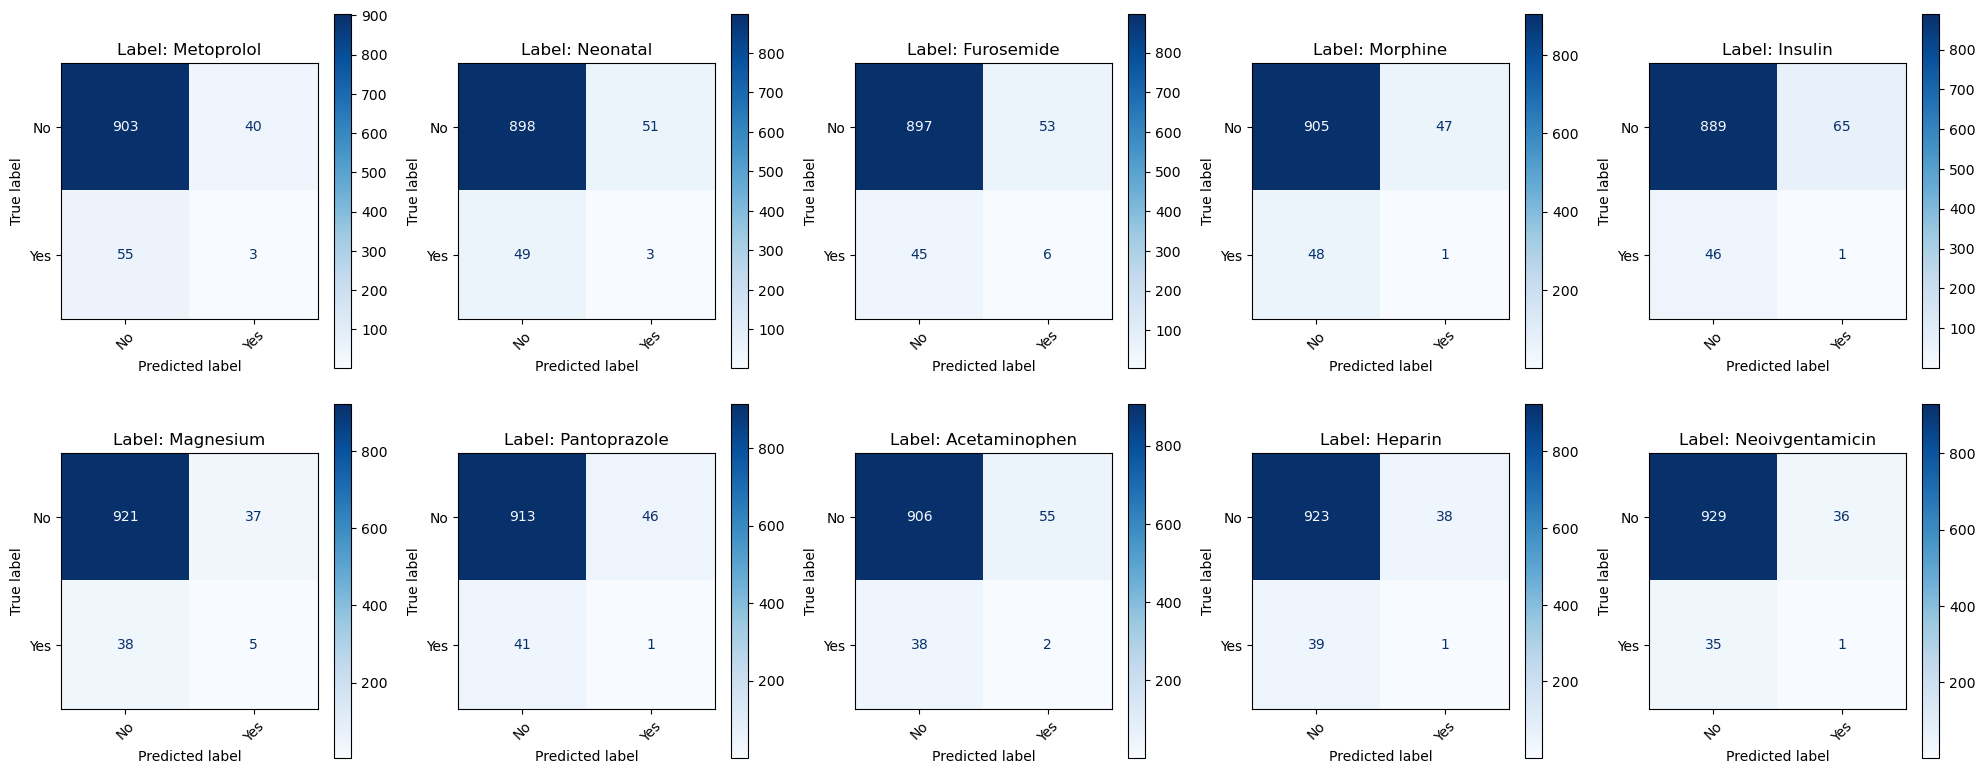

In [63]:
top_n = 10
label_sums = y_test_df.sum(axis=0)
top_labels = label_sums.sort_values(ascending=False).head(top_n).index.tolist()

# Filter confusion matrices and class names
label_indices = [list(mlb.classes_).index(label) for label in top_labels]
top_cm = conf_matrices[label_indices]

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, (cm, label) in enumerate(zip(top_cm, top_labels)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
    disp.plot(ax=axes[i], cmap="Blues", values_format='d')
    axes[i].set_title(f"Label: {label}")
    axes[i].tick_params(axis='x', rotation=45)

# Hide unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Above label level confusion matrix represents class imbalance high accuracy and low precision and recall

In [65]:
y_train_df.columns

Index(['Acetaminophen', 'Albuterol Neb Soln', 'Ampicillin', 'Aspirin',
       'Aspirin Ec', 'Atorvastatin', 'Bicarbonate', 'Bisacodyl',
       'Calcium Gluconate', 'Captopril', 'Chl', 'Clopidogrel Bisulfate',
       'Dextrose', 'Diphenhydramine Hcl', 'Docusate', 'Famotidine', 'Fentanyl',
       'Furosemide', 'Haloperidol', 'Heparin', 'Heparin Preservative Free',
       'Hydralazine Hcl', 'Hydromorphone', 'Insulin', 'Isoosmotic Dextrose',
       'Levofloxacin', 'Lisinopril', 'Lorazepam', 'Lr', 'Magnesium',
       'Metoclopramide', 'Metoprolol', 'Metronidazole', 'Midazolam Hcl',
       'Morphine', 'Neoivampicillin', 'Neoivgentamicin', 'Neonatal',
       'Neopoferrous Elixir', 'Neutraphos', 'Oxycodoneacetaminophen',
       'Pantoprazole', 'Phenylephrine Hcl', 'Phenytoin', 'Phosphate',
       'Prednisone', 'Propofol', 'Ranitidine', 'Senna', 'Soln',
       'Vancomycin Hcl', 'Warfarin'],
      dtype='object')

#### class balancing using SMOTE

In [67]:
#Oversampling and balancing using SMOTE
def multilabel_smote_oversample_force(X, y_df, target_count=1000):
    X_aug = X.copy()
    y_aug = y_df.copy()

    for label in y_df.columns:
        positives = y_df[label].sum()
        if positives < 5 or positives >= target_count:
            continue  # Skip too rare or already balanced

        y_binary = y_df[label]
        try:
            smote = SMOTE(
                sampling_strategy={1: target_count},
                k_neighbors=min(5, int(positives) - 1),
                random_state=42
            )
            # Run SMOTE on original data only
            X_res, y_res = smote.fit_resample(X, y_binary)

            # Identify new positive samples
            new_samples = X_res[len(X):]
            new_labels = y_res[len(X):]
            new_positive_rows = new_samples[new_labels == 1]

            # Copy full multilabels from real positives
            pos_rows = y_df[y_df[label] == 1]
            sampled_multilabels = pos_rows.sample(n=len(new_positive_rows), replace=True, random_state=42)

            # Append to augmented data
            X_aug = pd.concat([X_aug, pd.DataFrame(new_positive_rows, columns=X.columns)], ignore_index=True)
            y_aug = pd.concat([y_aug, sampled_multilabels.reset_index(drop=True)], ignore_index=True)

        except Exception as e:
            print(f"Label '{label}' skipped due to: {e}")
            continue

    return X_aug, y_aug
X_train_balanced, y_train_balanced = multilabel_smote_oversample_force(X_train_final_df, y_train_df)
print("Before:\n", y_train_df.sum().sort_values(ascending=False).head(10))
print("After:\n", y_train_balanced.sum().sort_values(ascending=False).head(10))
print(f"Training set size: {X_train_balanced.shape}. Training labels size: {y_train_balanced.shape}")

Before:
 Insulin                119
Furosemide             115
Metoprolol              98
Acetaminophen           93
Neonatal                90
Heparin                 74
Pantoprazole            70
Morphine                69
Isoosmotic Dextrose     66
Magnesium               62
dtype: int64
After:
 Acetaminophen         1000
Albuterol Neb Soln    1000
Lr                    1000
Magnesium             1000
Metoclopramide        1000
Metoprolol            1000
Metronidazole         1000
Midazolam Hcl         1000
Morphine              1000
Neoivampicillin       1000
dtype: int64
Training set size: (52000, 890). Training labels size: (52000, 52)


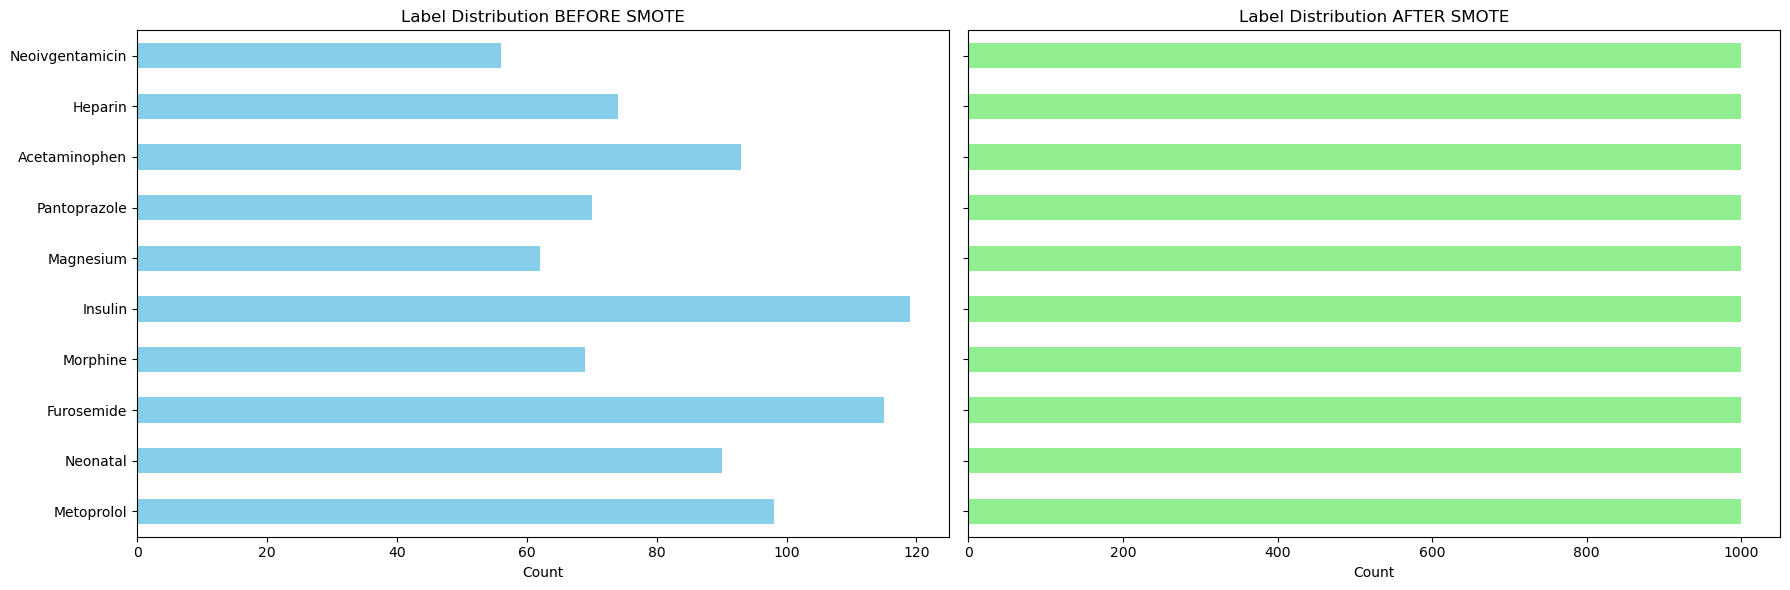

In [68]:
# Calculate label distributions for top 20 after SMOTE
TOP_K = 20  

# Get top K labels before and after
before_counts = y_train_df.sum().sort_values(ascending=False)
after_counts = y_train_balanced.sum().sort_values(ascending=False)
before_top = before_counts.loc[top_labels]
after_top = after_counts.loc[top_labels]
top_labels = before_counts.head(TOP_K).index
# Create a comparison plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

before_top.plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_title("Label Distribution BEFORE SMOTE")
axes[0].set_xlabel("Count")
axes[0].invert_yaxis()

after_top.plot(kind='barh', ax=axes[1], color='lightgreen')
axes[1].set_title("Label Distribution AFTER SMOTE")
axes[1].set_xlabel("Count")

plt.tight_layout()
plt.show()

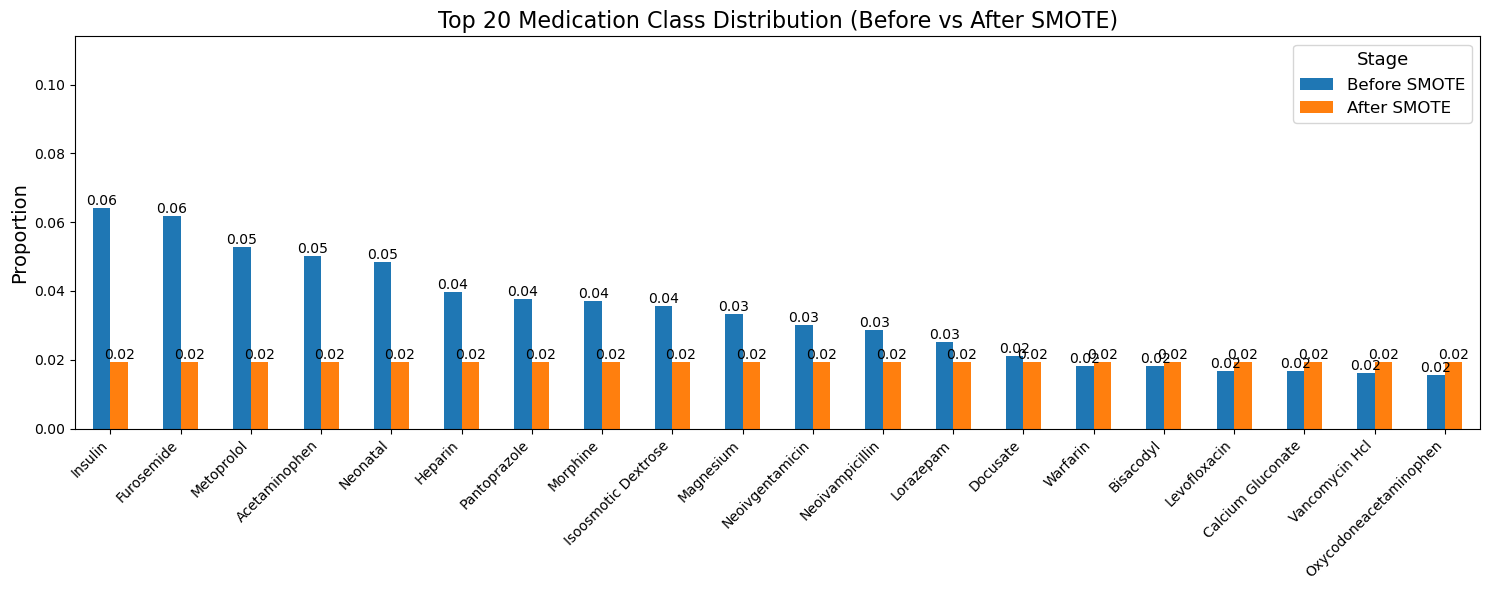

In [185]:
top_10_labels = y_train_df.sum().sort_values(ascending=False).head(20).index.tolist()

# Step 2: Calculate normalized frequencies for those top labels
before_distribution = y_train_df[top_10_labels].sum() / len(y_train_df)
after_distribution = y_train_balanced[top_10_labels].sum() / len(y_train_balanced)

# Step 3: Create a DataFrame for plotting
y_train_distribution_df = pd.DataFrame({
    'Before SMOTE': before_distribution,
    'After SMOTE': after_distribution
})

# Step 4: Plot
ax = y_train_distribution_df.plot(kind='bar', figsize=(15, 6))
plt.title("Top 20 Medication Class Distribution (Before vs After SMOTE)", fontsize=16)
plt.ylabel("Proportion", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, y_train_distribution_df.values.max() + 0.05)
plt.legend(title="Stage", fontsize=12, title_fontsize=13)

# Add bar labels
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=10)

plt.tight_layout()
plt.show()

In [73]:
y_train_balanced = y_train_balanced.fillna(0)

#### Label distribution after SMOTE

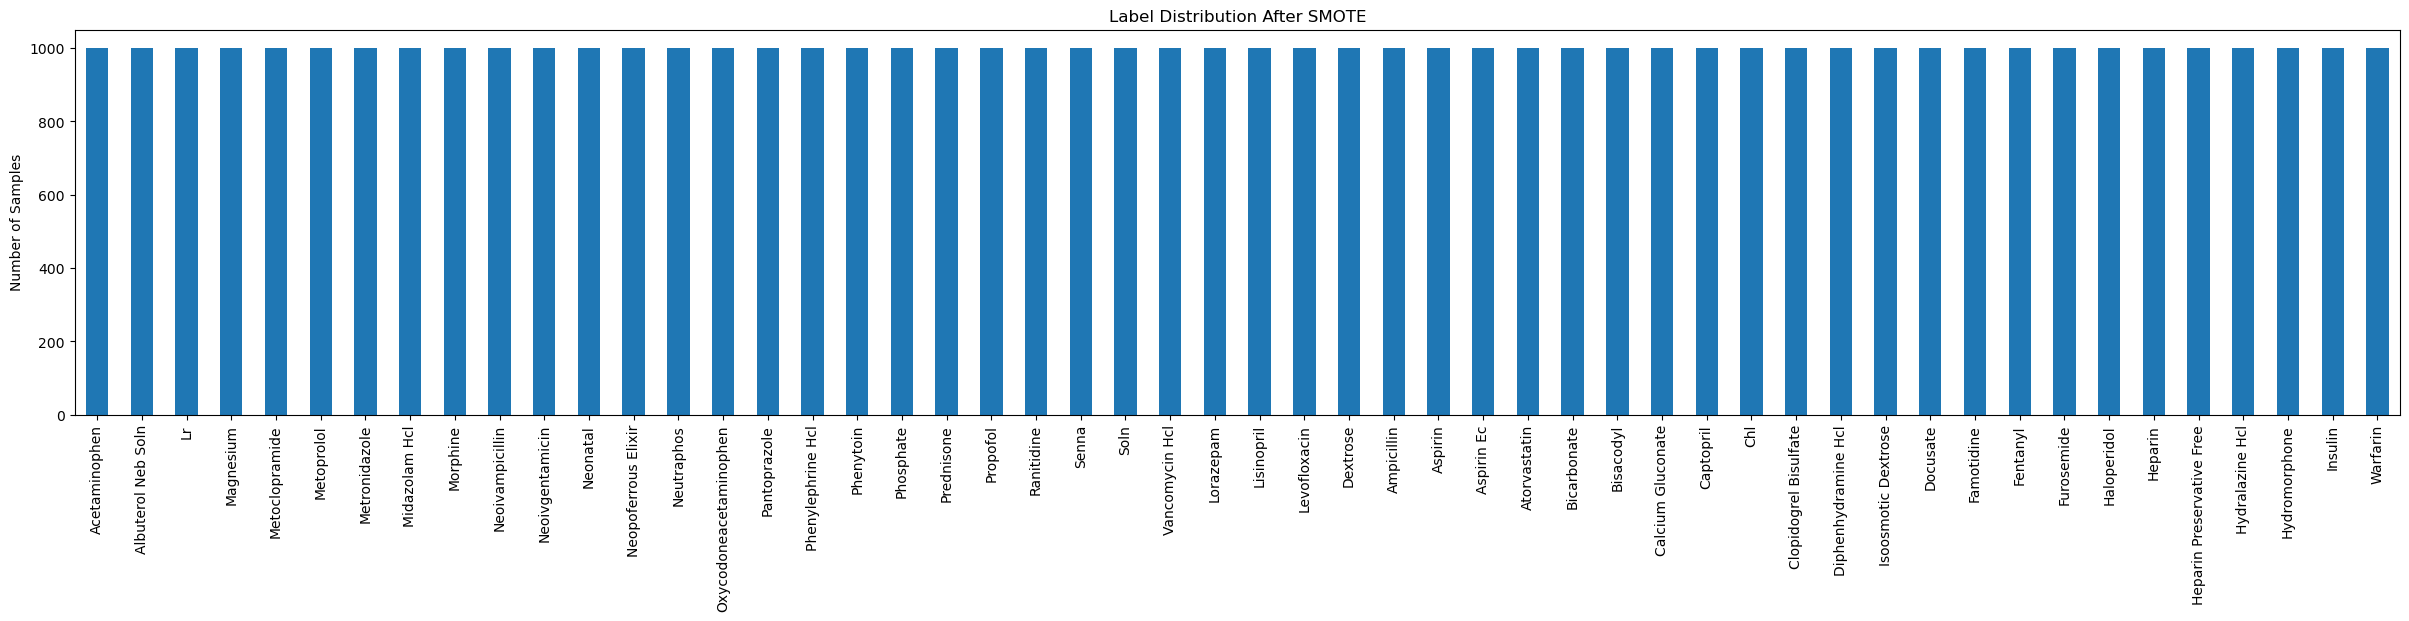

In [75]:
label_counts = y_train_balanced.sum().sort_values(ascending=False)
label_counts.plot(kind='bar', figsize=(30, 5), title="Label Distribution After SMOTE")
plt.ylabel("Number of Samples")
plt.show()

Baseline Accuracy: 0.01
Baseline Precision: 0.04
Baseline Recall: 0.02
Baseline F1 Score: 0.03


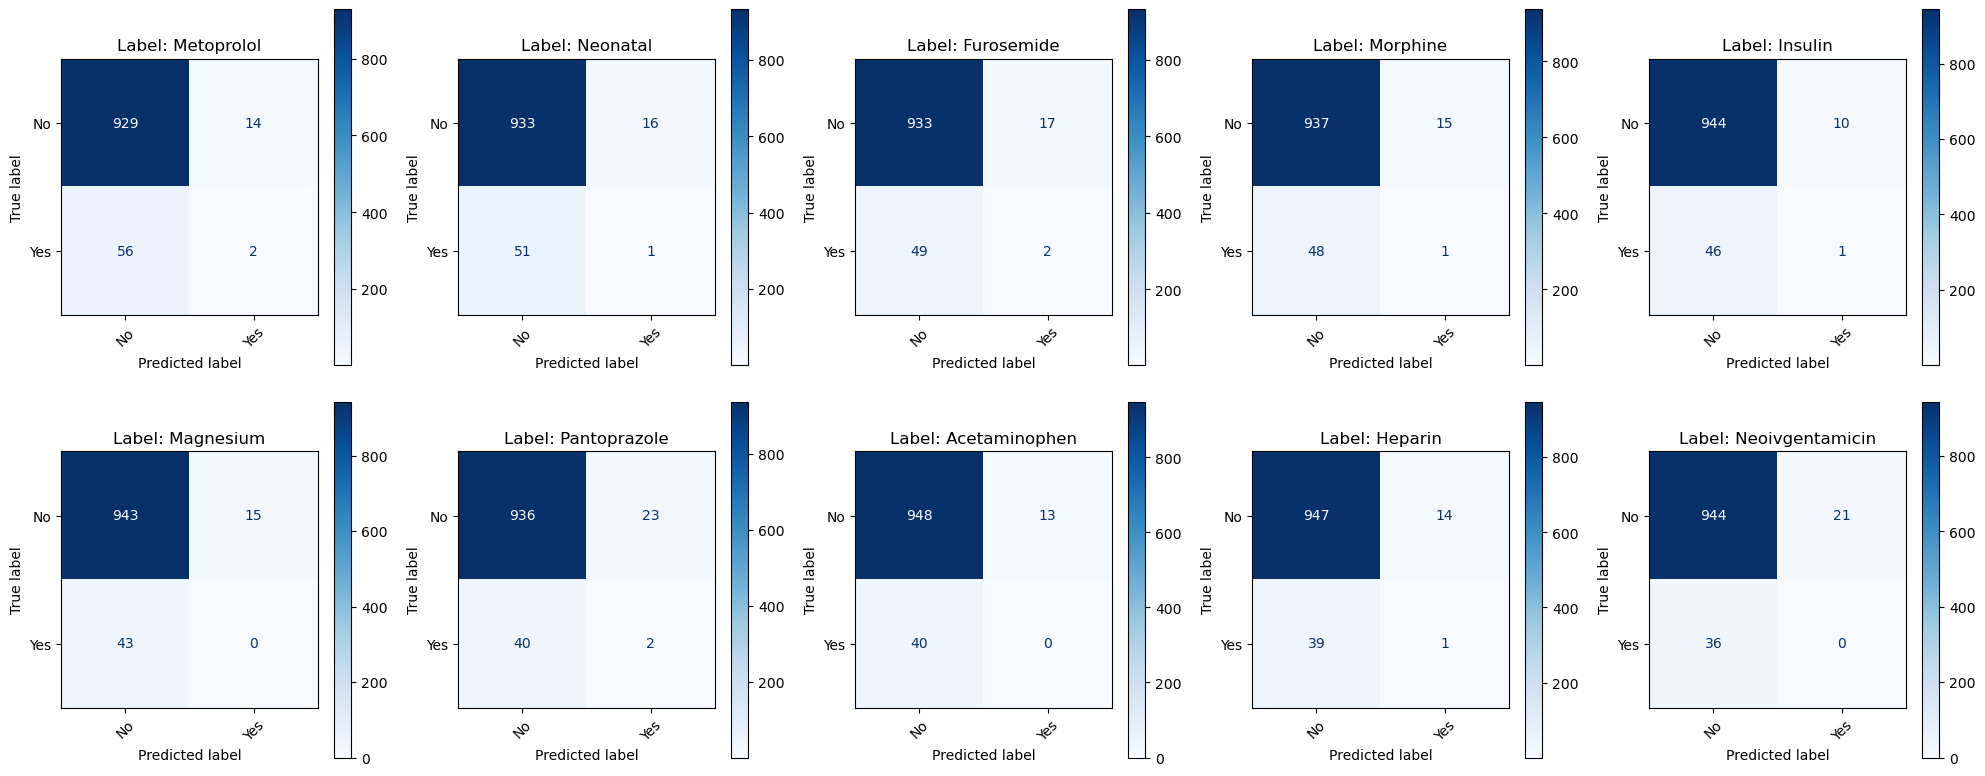

In [77]:
#A baseline model helps us understand whether our machine learning model is actually learning patterns or just memorizing class imbalances. 
# A random baseline (Dummy with stratified) shows performance without any predictive power, 
# while a dummy majority-class baseline (Dummy with most_frequent) reveals whether the model is just favoring the dominant class. 
# Comparing against these ensures that our model adds real value beyond guessing.

random_baseline = OneVsRestClassifier(DummyClassifier(strategy='stratified')) 
random_baseline.fit(X_train_balanced, y_train_balanced)
y_random_pred = random_baseline.predict(X_test_final_df)

accuracy_baseline = accuracy_score(y_test_df, y_random_pred)
precision_baseline = precision_score(y_test_df, y_random_pred, average='weighted', zero_division=0)
recall_baseline = recall_score(y_test_df, y_random_pred, average='weighted', zero_division=0)
f1_baseline = f1_score(y_test_df, y_random_pred,average='weighted', zero_division=0)
conf_matrices_sm = multilabel_confusion_matrix(y_test_df, y_random_pred)  

print(f"Baseline Accuracy: {accuracy_baseline:.2f}")
print(f"Baseline Precision: {precision_baseline:.2f}")
print(f"Baseline Recall: {recall_baseline:.2f}")
print(f"Baseline F1 Score: {f1_baseline:.2f}")


top_n = 10
label_sums = y_test_df.sum(axis=0)
top_labels = label_sums.sort_values(ascending=False).head(top_n).index.tolist()

# Filter confusion matrices and class names
label_indices = [list(mlb.classes_).index(label) for label in top_labels]
top_cm = conf_matrices_sm[label_indices]

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, (conf_matrices_sm, label) in enumerate(zip(top_cm, top_labels)):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrices_sm, display_labels=["No", "Yes"])
    disp.plot(ax=axes[i], cmap="Blues", values_format='d')
    axes[i].set_title(f"Label: {label}")
    axes[i].tick_params(axis='x', rotation=45)

# Hide unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
    

In [79]:
#Simple model train using OneVsRestClassifier and LogisticRegression
lgr_model = OneVsRestClassifier(LogisticRegression(solver='saga', random_state=42, n_jobs=-1))
few_labels = y_train_balanced.columns[:10]
lgr_model.fit(X_train_balanced,y_train_balanced[few_labels])

OneVsRestClassifier(estimator=LogisticRegression(n_jobs=-1, random_state=42,
                                                 solver='saga'))

In [81]:
y_pred_lgr = lgr_model.predict(X_test_final_df)

test_accuracy = accuracy_score(y_test_df[few_labels],y_pred_lgr)
train_accuracy = lgr_model.score(X_train_balanced,y_train_balanced[few_labels])

print(f"Logistic Regression Training Accuracy: {train_accuracy:.2f}")
print(f"Logistic Regression Test Accuracy: {test_accuracy:.2f}")
print("\n Classification report:")
print(classification_report(y_test_df[few_labels],y_pred_lgr))

Logistic Regression Training Accuracy: 0.81
Logistic Regression Test Accuracy: 0.84

 Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00        15
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        19
           8       0.00      0.00      0.00        23
           9       0.00      0.00      0.00        15

   micro avg       0.00      0.00      0.00       164
   macro avg       0.00      0.00      0.00       164
weighted avg       0.00      0.00      0.00       164
 samples avg       0.00      0.00      0.00       164



In [83]:
from sklearn.metrics import hamming_loss

score = hamming_loss(y_test_df[few_labels],y_pred_lgr)
print("Hamming loss:", score)

# On average, 1.64% of the labels per sample are predicted incorrectly.
# Or put positively: 98.36% of the labels are correct, which is fairly decent — especially in a multi-label setting.

Hamming loss: 0.016383616383616385


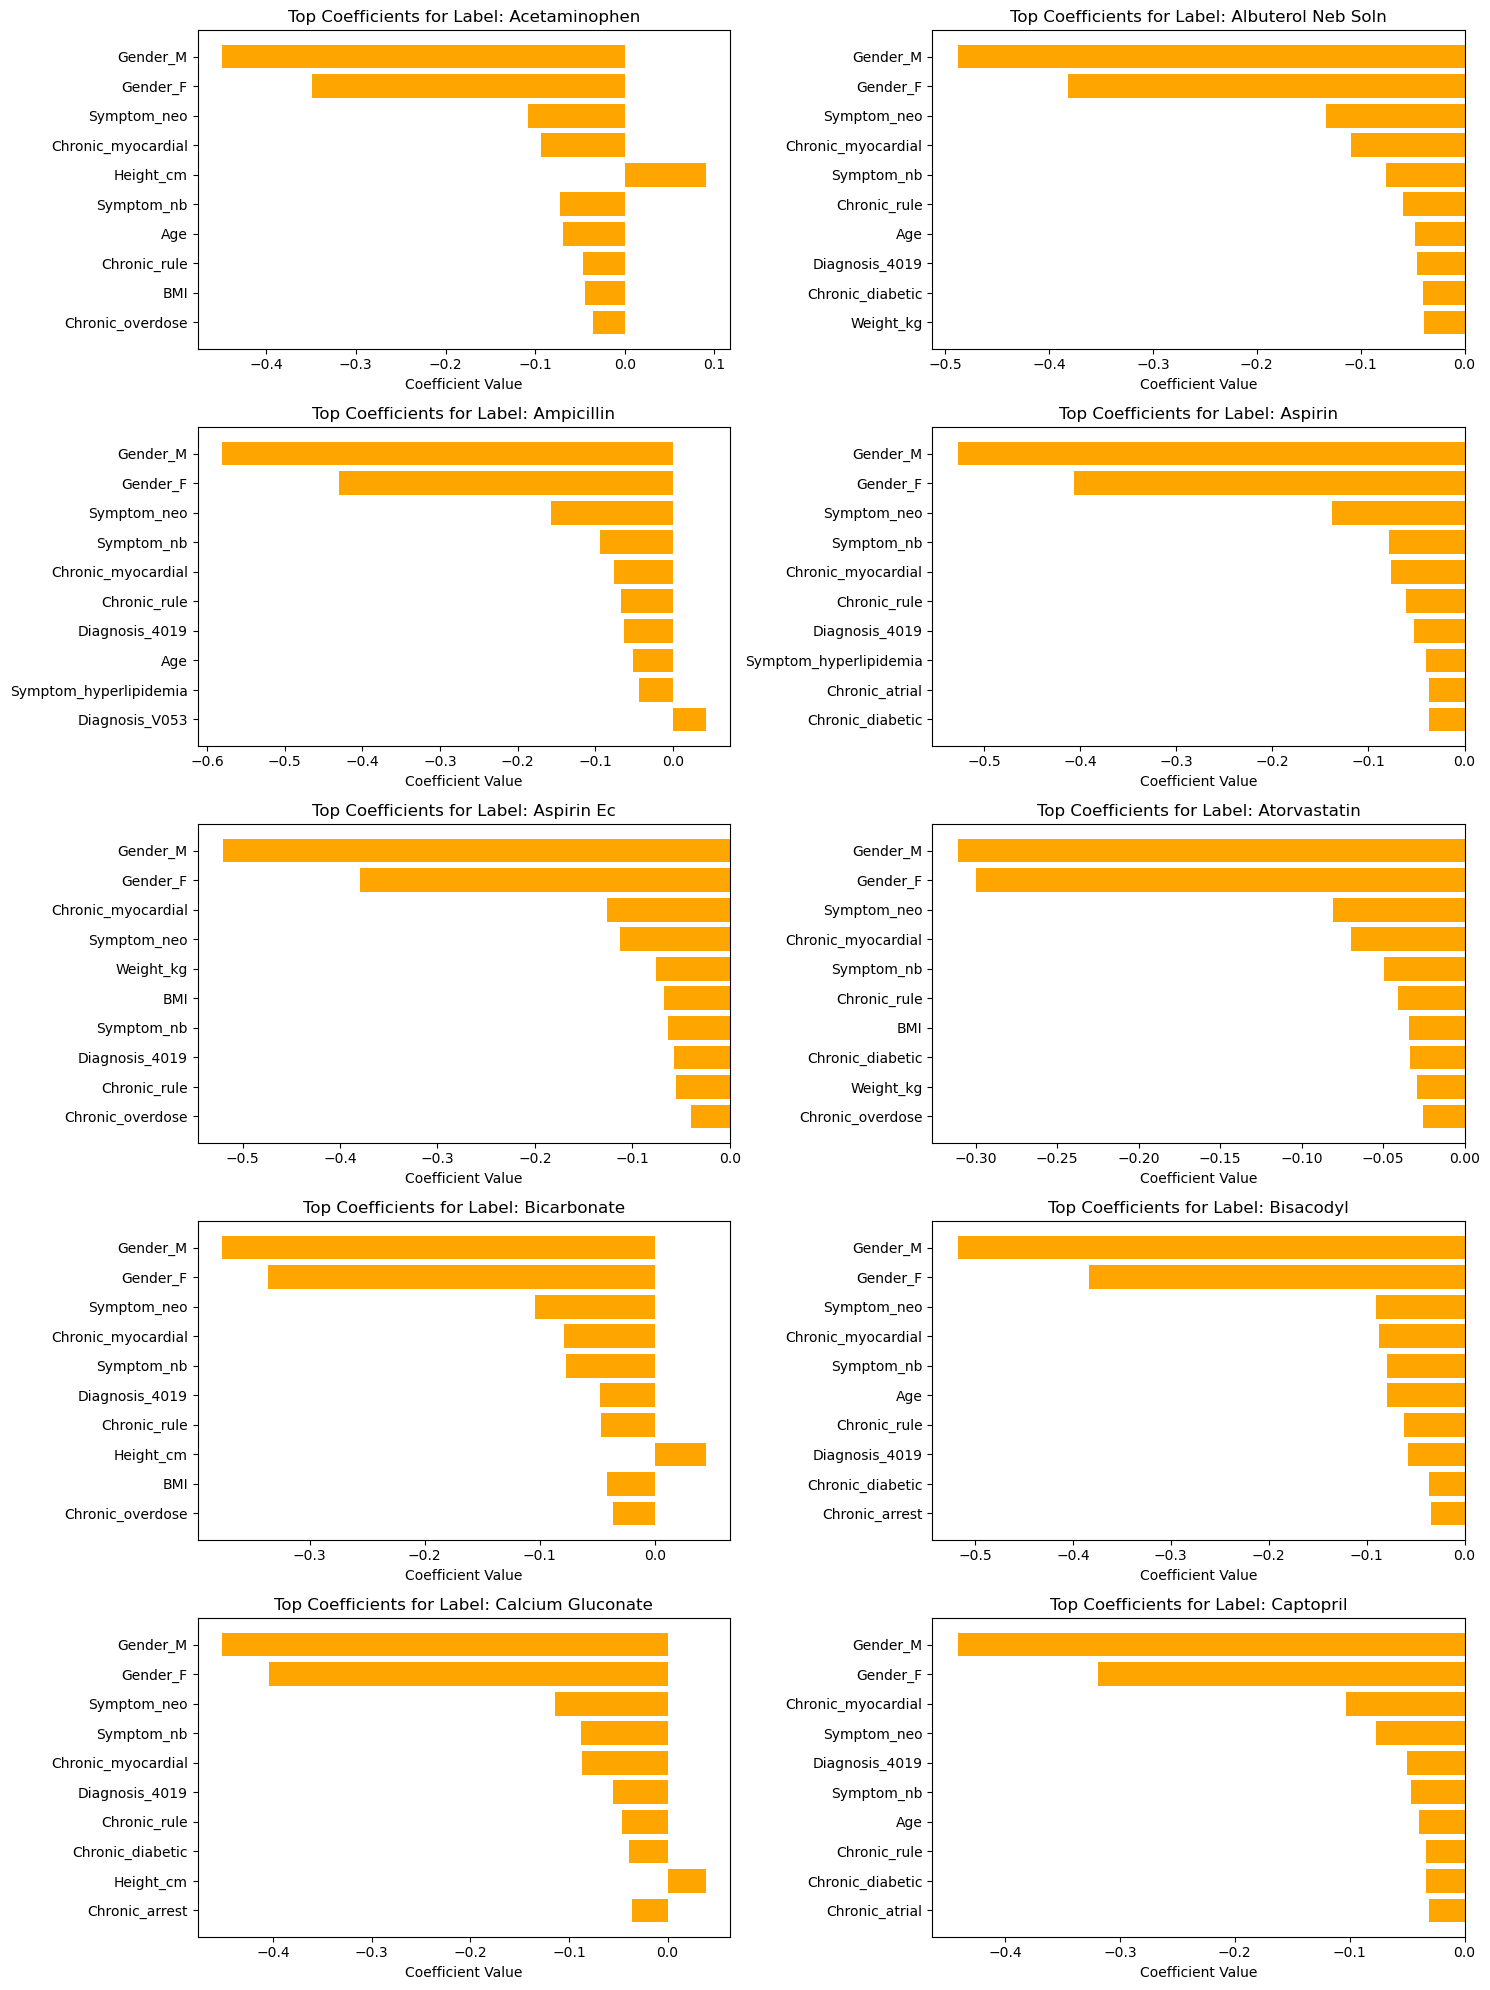

In [85]:
feature_names = X_train_balanced.columns
n_labels = len(y_train_balanced[few_labels].columns)
n_cols = 2
n_rows = (n_labels + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, clf in enumerate(lgr_model.estimators_):
    label = y_train_balanced[few_labels] .columns[i]
    coefs = clf.coef_[0]  # shape: (n_features,)
    
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefs
    }).sort_values(by='Coefficient', key=abs, ascending=False).head(10)

    ax = axes[i]
    ax.barh(coef_df['Feature'], coef_df['Coefficient'], color='orange')
    ax.set_title(f"Top Coefficients for Label: {label}")
    ax.set_xlabel("Coefficient Value")
    ax.invert_yaxis()

# Hide any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Insights on Logistic Regression metrics:

* This is a multi-label classification problem, the high accuracy on train and test with 0 recall/precision indicates the model is predicting only the majority labels. 

In [ ]:
import warnings
from sklearn.base import clone
warnings.filterwarnings('ignore')

#create list to train models
models_train = {
    'Decision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=42,max_depth=5,             
                                            min_samples_split=10,min_samples_leaf=5,ccp_alpha=0.01)),
    'Random Forest': OneVsRestClassifier(RandomForestClassifier(n_estimators=100, n_jobs=-1,
                                                                random_state=42,max_depth=10,               
                                                                min_samples_leaf=5, max_features='sqrt',
                                                                  class_weight='balanced')),
    'LightGBM': OneVsRestClassifier(LGBMClassifier(n_estimators=100,learning_rate=0.1,max_depth=6,
                                                    min_child_samples=20,subsample=0.8,             
                                                    colsample_bytree=0.8,reg_alpha=0.1,reg_lambda=1.0,
                                                   random_state=42, class_weight='balanced',verbose=-1)),
    'XGBoost': OneVsRestClassifier(XGBClassifier(
        n_estimators=100, eval_metric='logloss', random_state=42,max_depth=4, min_child_weight=5,       
    subsample=0.7,colsample_bytree=0.7,reg_alpha=0.5,reg_lambda=1.0,scale_pos_weight=1))
    
}
results_m = []
trained_models = {}
selected_features_per_model = {}
num_features_to_select = 20

for model_name, model in models_train.items():
    print(f"Training and evaluating {model_name}")
    

    model_fs = clone(model)
 # Train the model on full training data and predict on the test set
    model_fs.fit(X_train_final_df, y_train_df)
   

    # Store trained model
    trained_models[model_name] = model_fs

    if hasattr(model_fs, 'estimators_'):
        try:
            all_importances = []

            for est in model_fs.estimators_:
                if hasattr(est, "feature_importances_"):
                    all_importances.append(est.feature_importances_)
                else:
                    raise AttributeError("Base estimator does not have feature_importances_")

            importances_array = np.array(all_importances)
            averaged_importances = pd.Series(importances_array.mean(axis=0), index=X_train_final_df.columns)

            # Select top N features
            top_features = averaged_importances.nlargest(num_features_to_select).index.tolist()
            selected_features_per_model[model_name] = top_features

            # Use selected features
            X_train_selected = X_train_final_df[top_features]
            X_test_selected = X_test_final_df[top_features]

        except Exception as e:
            print(f"  Could not extract importances for {model_name}: {e}")
            X_train_selected = X_train_final_df
            X_test_selected = X_test_final_df
    else:
        X_train_selected = X_train_final_df
        X_test_selected = X_test_final_df

    

    model_fs = clone(model)
    model_fs.fit(X_train_selected, y_train_df)
    
    y_train_pred = model_fs.predict(X_train_selected)
    y_test_pred = model_fs.predict(X_test_selected)
    # Compute train metrics
    train_accuracy = accuracy_score(y_train_df, y_train_pred)
    train_precision = precision_score(y_train_df, y_train_pred, average='weighted', zero_division=0)
    train_recall = recall_score(y_train_df, y_train_pred, average='weighted', zero_division=0)
    train_f1 = f1_score(y_train_df, y_train_pred, average='weighted', zero_division=0)

    # Compute test metrics
    test_accuracy = accuracy_score(y_test_df, y_test_pred)
    test_precision = precision_score(y_test_df, y_test_pred, average='weighted', zero_division=0)
    test_recall = recall_score(y_test_df, y_test_pred, average='weighted', zero_division=0)
    test_f1 = f1_score(y_test_df, y_test_pred, average='weighted', zero_division=0)

    # Store results
    results_m.append({
        "Model": model_name,
        "Train Accuracy": train_accuracy,
        "Train Precision": train_precision,
        "Train Recall": train_recall,
        "Train F1": train_f1,
        "Test Accuracy": test_accuracy,
        "Test Precision": test_precision,
        "Test Recall": test_recall,
        "Test F1": test_f1,
    })


In [89]:
results_df_m = pd.DataFrame(results_m).sort_values(by="Test F1",ascending=False)
print(results_df_m)

           Model  Train Accuracy  Train Precision  Train Recall  Train F1  \
2       LightGBM        0.860140         0.893017      1.000000  0.932716   
3        XGBoost        0.603012         0.864505      0.603550  0.681692   
0  Decision Tree        0.401291         0.541829      0.401291  0.437821   
1  Random Forest        0.590640         0.715695      0.987090  0.805115   

   Test Accuracy  Test Precision  Test Recall   Test F1  
2       0.798202        0.850477     0.898102  0.856872  
3       0.401598        0.737968     0.403596  0.484350  
0       0.383616        0.518063     0.383616  0.414815  
1       0.228771        0.488755     0.441558  0.392883  


LightGBM with 0.85 with perfect train recall indicates better generalization than the other models

In [91]:
print("\nTop Features Selected by Each Model:")
for model_name, features in selected_features_per_model.items():
    print(f"\n{model_name} (Top {len(features)} features):")
    for i, feature in enumerate(features, 1):
        print(f"  {i}. {feature}")


Top Features Selected by Each Model:

Decision Tree (Top 20 features):
  1. Chronic_wound
  2. Age
  3. Weight_kg
  4. Height_cm
  5. BMI
  6. Gender_F
  7. Gender_M
  8. Diagnosis_00845
  9. Diagnosis_0090
  10. Diagnosis_0380
  11. Diagnosis_03811
  12. Diagnosis_03849
  13. Diagnosis_0389
  14. Diagnosis_04104
  15. Diagnosis_04111
  16. Diagnosis_04185
  17. Diagnosis_04186
  18. Diagnosis_04189
  19. Diagnosis_042
  20. Diagnosis_07032

Random Forest (Top 20 features):
  1. Chronic_wound
  2. Age
  3. Height_cm
  4. Weight_kg
  5. BMI
  6. Symptom_neo
  7. Symptom_nb
  8. Chronic_rule
  9. Gender_M
  10. Chronic_carotid
  11. Gender_F
  12. Chronic_copd
  13. Chronic_diabetic
  14. Chronic_atrial
  15. Chronic_overdose
  16. Chronic_arrest
  17. Chronic_myocardial
  18. Chronic_exacerbation
  19. Symptom_crnry
  20. Diagnosis_41401

LightGBM (Top 20 features):
  1. Chronic_wound
  2. Weight_kg
  3. Height_cm
  4. Age
  5. BMI
  6. Symptom_neo
  7. Symptom_nb
  8. Chronic_rule
  9

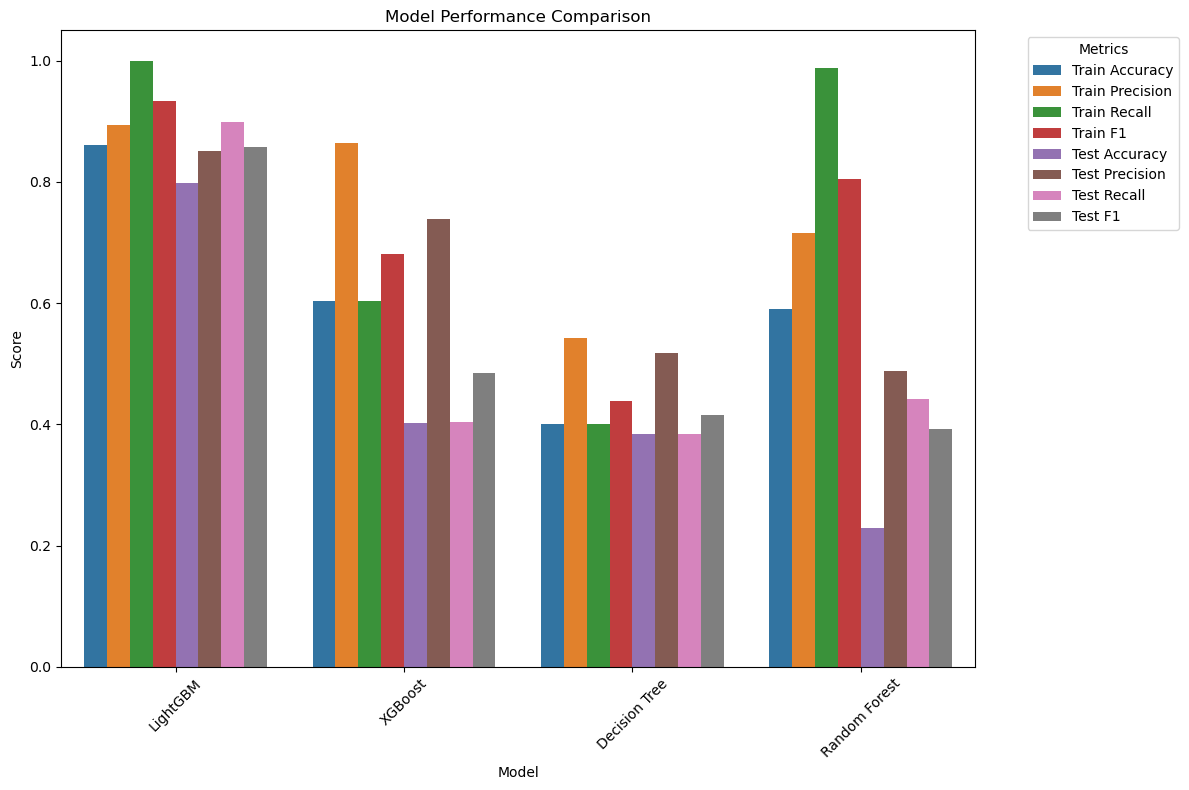

In [93]:
plt.figure(figsize=(12,8))
df_melted = results_df_m.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(x='Model',y='Score', hue='Metric',data=df_melted)
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

In [ ]:
#balanced set
models_train = {
    'Decision Tree': OneVsRestClassifier(DecisionTreeClassifier(random_state=42,max_depth=5,             
                                            min_samples_split=10,min_samples_leaf=5,ccp_alpha=0.01)),
    'Random Forest': OneVsRestClassifier(RandomForestClassifier(n_estimators=100, n_jobs=-1,
                                                                random_state=42,max_depth=10,               
                                                                min_samples_leaf=5, max_features='sqrt',
                                                                  class_weight='balanced')),
    'LightGBM': OneVsRestClassifier(LGBMClassifier(n_estimators=100,learning_rate=0.1,max_depth=6,
                                                    min_child_samples=20,subsample=0.8,             
                                                    colsample_bytree=0.8,reg_alpha=0.1,reg_lambda=1.0,
                                                   random_state=42, class_weight='balanced',verbose=-1)),
    'XGBoost': OneVsRestClassifier(XGBClassifier(
        n_estimators=100, eval_metric='logloss', random_state=42,max_depth=4, min_child_weight=5,       
    subsample=0.7,colsample_bytree=0.7,reg_alpha=0.5,reg_lambda=1.0,scale_pos_weight=1))
    
}
results_m = []
trained_models_b = {}
selected_features_per_model_balanced = {}
num_features_to_select = 20


for model_name, model in models_train.items():
    print(f"\nTraining and evaluating {model_name}")
    model_b_fs = clone(model)

    # Train on full training set initially
    model_b_fs.fit(X_train_balanced, y_train_balanced)
    trained_models_b[model_name] = model_b_fs

    X_train_selected = X_train_balanced
    X_test_selected = X_test_final_df

    # Select top features based on feature importances
    try:
    # Get all individual classifiers from OneVsRestClassifier
        all_importances = []
        for est in model_b_fs.estimators_:
            if hasattr(est, "feature_importances_"):
                all_importances.append(est.feature_importances_)
    
        if not all_importances:
            raise ValueError("No base estimator has feature_importances_.")
    
        importances_array = np.array(all_importances)
        averaged_importances = pd.Series(importances_array.mean(axis=0), index=X_train_balanced.columns)
        top_features = averaged_importances.nlargest(num_features_to_select).index.tolist()
    
        print(f"  Selected features: {top_features}")
        selected_features_per_model_balanced[model_name] = top_features
    
        # Filter data to top features
        X_train_selected = X_train_balanced[top_features]
        X_test_selected = X_test_final_df[top_features]

        # Retrain model on selected features
        model_b_fs = clone(model)
        model_b_fs.fit(X_train_selected, y_train_balanced)
        trained_models_b[model_name] = model_b_fs


    except Exception as e:
        print(f"  Could not extract importances for {model_name}: {e}")

    
    y_train_pred = model_b_fs.predict(X_train_selected)
    y_test_pred = model_b_fs.predict(X_test_selected)

   

    # Compute train metrics
    train_accuracy = accuracy_score(y_train_balanced, y_train_pred)
    train_precision = precision_score(y_train_balanced, y_train_pred, average='weighted', zero_division=0)
    train_recall = recall_score(y_train_balanced, y_train_pred, average='weighted', zero_division=0)
    train_f1 = f1_score(y_train_balanced, y_train_pred, average='weighted', zero_division=0)

    # Compute test metrics
    test_accuracy = accuracy_score(y_test_df, y_test_pred)
    test_precision = precision_score(y_test_df, y_test_pred, average='weighted', zero_division=0)
    test_recall = recall_score(y_test_df, y_test_pred, average='weighted', zero_division=0)
    test_f1 = f1_score(y_test_df, y_test_pred, average='weighted', zero_division=0)

    # Store results
    results_m.append({
        "Model": model_name,
        "Train Accuracy": train_accuracy,
        "Train Precision": train_precision,
        "Train Recall": train_recall,
        "Train F1": train_f1,
        "Test Accuracy": test_accuracy,
        "Test Precision": test_precision,
        "Test Recall": test_recall,
        "Test F1": test_f1,
    })

In [97]:
results_balanced_m = pd.DataFrame(results_m).sort_values(by="Test F1",ascending=False)
print(results_balanced_m)

           Model  Train Accuracy  Train Precision  Train Recall  Train F1  \
2       LightGBM        0.926096         0.938279      1.000000  0.963344   
3        XGBoost        0.871981         0.940059      0.878269  0.894516   
1  Random Forest        0.440885         0.650837      0.997519  0.747506   
0  Decision Tree        0.326077         0.383496      0.326077  0.348804   

   Test Accuracy  Test Precision  Test Recall   Test F1  
2       0.698302        0.791101     0.846154  0.802990  
3       0.712288        0.839525     0.718282  0.747293  
1       0.179820        0.441596     0.557443  0.453620  
0       0.247752        0.295804     0.247752  0.265671  


### Model Evaluation Metrics
##### LightGBM:
The evaluation metrics for the trained models — both before and after label balancing — consistently show that LightGBM performs best across key classification metrics:

* Accuracy: LightGBM achieves the highest accuracy, indicating the greatest proportion of correctly predicted instances overall.
* Precision: It maintains high precision, meaning it generates fewer false positive predictions.
* Recall: With recall near 1.0, it successfully captures almost all true positives, minimizing false negatives.
* F1 Score: LightGBM also has the highest F1 score, balancing precision and recall effectively.
In both the training and test datasets, LightGBM shows strong performance, especially in the Test F1 score, which is a key indicator of generalization.

##### XGBoost:

* Accuracy: XGBoost achieves the good test accuracy, indicating the greatest proportion of correctly predicted instances overall, but lower Test F1
* Precision: It maintains high test precision, meaning it generates fewer false positive predictions.
* Recall: With recall 0.71, the generalization is lower than LightGBM
In both the training and test datasets, XGBoost shows fair performance, closer to LightGBM and can be a good model to use for classification

##### RandomForest:

* Near perfect train recall but lower test recall incicating overfitting

##### Decision Tree:

* weakest amongst trained models with lower metrics scoring overall
  

In [99]:
print("\nTop Features Selected by Each Model:")
for model_name, features in selected_features_per_model_balanced.items():
    print(f"\n{model_name} (Top {len(features)} features):")
    for i, feature in enumerate(features, 1):
        print(f"  {i}. {feature}")


Top Features Selected by Each Model:

Decision Tree (Top 20 features):
  1. Chronic_wound
  2. Age
  3. Weight_kg
  4. Height_cm
  5. BMI
  6. Gender_F
  7. Gender_M
  8. Diagnosis_00845
  9. Diagnosis_0090
  10. Diagnosis_0380
  11. Diagnosis_03811
  12. Diagnosis_03849
  13. Diagnosis_0389
  14. Diagnosis_04104
  15. Diagnosis_04111
  16. Diagnosis_04185
  17. Diagnosis_04186
  18. Diagnosis_04189
  19. Diagnosis_042
  20. Diagnosis_07032

Random Forest (Top 20 features):
  1. Chronic_wound
  2. BMI
  3. Height_cm
  4. Weight_kg
  5. Age
  6. Gender_M
  7. Gender_F
  8. Chronic_rule
  9. Symptom_nb
  10. Symptom_neo
  11. Diagnosis_4019
  12. Chronic_arrest
  13. Chronic_atrial
  14. Symptom_mitral
  15. Chronic_diabetic
  16. Chronic_copd
  17. Diagnosis_V053
  18. Chronic_carotid
  19. Chronic_myocardial
  20. Diagnosis_41401

LightGBM (Top 20 features):
  1. Chronic_wound
  2. Height_cm
  3. Weight_kg
  4. Age
  5. BMI
  6. Gender_F
  7. Symptom_neo
  8. Gender_M
  9. Chronic_rul

In [101]:
trained_models[model_name].estimators_[0].feature_names_in_

array(['Age', 'Weight_kg', 'Height_cm', 'BMI', 'Gender_F', 'Gender_M',
       'Diagnosis_00845', 'Diagnosis_0090', 'Diagnosis_0380',
       'Diagnosis_03811', 'Diagnosis_03849', 'Diagnosis_0389',
       'Diagnosis_04104', 'Diagnosis_04111', 'Diagnosis_04185',
       'Diagnosis_04186', 'Diagnosis_04189', 'Diagnosis_042',
       'Diagnosis_07032', 'Diagnosis_07054', 'Diagnosis_07951',
       'Diagnosis_07999', 'Diagnosis_1120', 'Diagnosis_1122',
       'Diagnosis_11289', 'Diagnosis_1173', 'Diagnosis_1231',
       'Diagnosis_135', 'Diagnosis_1363', 'Diagnosis_1420',
       'Diagnosis_1505', 'Diagnosis_1540', 'Diagnosis_1541',
       'Diagnosis_1548', 'Diagnosis_1550', 'Diagnosis_1623',
       'Diagnosis_1628', 'Diagnosis_1629', 'Diagnosis_1729',
       'Diagnosis_1748', 'Diagnosis_185', 'Diagnosis_1890',
       'Diagnosis_1891', 'Diagnosis_1919', 'Diagnosis_1962',
       'Diagnosis_1965', 'Diagnosis_1966', 'Diagnosis_1970',
       'Diagnosis_1972', 'Diagnosis_1974', 'Diagnosis_1976',
    

In [103]:
X_test_final_df[top_features].columns

Index(['Chronic_wound', 'Symptom_hepat', 'Chronic_graft', 'Diagnosis_4373',
       'Diagnosis_4019', 'Chronic_atrial', 'Chronic_minimally',
       'Diagnosis_V3000', 'Diagnosis_2760', 'NDC_encoded', 'Symptom_aortic',
       'Symptom_subarachnoid', 'Diagnosis_V3101', 'Chronic_diabetic',
       'Symptom_organism', 'Diagnosis_4241', 'Diagnosis_V642', 'Chronic_bowel',
       'Diagnosis_99592', 'Symptom_cl'],
      dtype='object')

In [105]:
#model evaluation on test dataset
results_ev = {}

for model_name, model in trained_models.items():
    # Predict on the test set
    model_features = model.estimators_[0].feature_names_in_
    X_test_for_model = X_test_final_df.loc[:, model_features].copy()
    y_pred = model.predict(X_test_for_model)

    # Calculate metrics
    accuracy = accuracy_score(y_test_df, y_pred)
    precision = precision_score(y_test_df, y_pred,average='weighted')
    recall = recall_score(y_test_df, y_pred,average='weighted')
    f1 = f1_score(y_test_df, y_pred,average='weighted')
    
    conf_matrices = multilabel_confusion_matrix(y_test_df, y_pred)

    # Store the results in the dictionary
    results_ev[model_name] = {
        'Accuracy': accuracy,
        'Precision':precision,
        'Recall': recall,
        'F1-Score': f1,
        'Confusion Matrix':conf_matrices
       
    }

#### Model evaluation on test dataset:

LightGBM represents better F1-Score than the rest of the model, showing better generalization.


In [107]:
results_df_ev = pd.DataFrame(results_ev).T.sort_values(by=['F1-Score'],ascending=False)
results_df_ev

,Accuracy,Precision,Recall,F1-Score,Confusion Matrix
LightGBM,0.806194,0.858158,0.897103,0.860821,"[[[957, 4], [2, 38]], [[987, 4], [0, 10]], [[9..."
XGBoost,0.440559,0.728588,0.441558,0.515578,"[[[958, 3], [6, 34]], [[991, 0], [6, 4]], [[99..."
Decision Tree,0.351648,0.480101,0.351648,0.380849,"[[[961, 0], [26, 14]], [[991, 0], [10, 0]], [[..."
Random Forest,0.078921,0.184998,0.320679,0.21173,"[[[801, 160], [27, 13]], [[940, 51], [9, 1]], ..."


In [111]:
results_df = pd.DataFrame(results_cv).T.sort_values('CV F1 Weighted (mean)', ascending=False)
results_df

,Model,CV F1 Weighted (mean),CV F1 Weighted (std),Test Accuracy
LightGBM,LightGBM,0.581135,0.352442,0.745255
Random Forest,Random Forest,0.229664,0.11143,0.08991
XGBoost,XGBoost,0.128084,0.027437,0.542458
Decision Tree,Decision Tree,0.004292,0.003093,0.092907


#Cross-Validation scoring using conditional Mutioutputclassifier

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
# Use F1-score for multi-label classification
f1_weighted_scorer = make_scorer(f1_score, average='weighted', zero_division=0)

results_cv = {}

for model_name, model in models_train.items():
    print(f"\nTraining and evaluating {model_name} with cross-validation...")

    # Wrap in MultiOutputClassifier if base estimator doesn't support multilabel
    if not isinstance(model, OneVsRestClassifier):
        model = MultiOutputClassifier(model)

    # Perform cross-validation
    cv_results = cross_validate(
        model,
        X_train_balanced,
        y_train_balanced,
        scoring=f1_weighted_scorer,
        cv=3,  # Reduce folds if it's slow
        n_jobs=-1,
        return_train_score=True
    )

    # Fit on full training data
    model.fit(X_train_balanced, y_train_balanced)

    # Get feature names
    try:
        base_estimator = model.estimators_[0] if isinstance(model, OneVsRestClassifier) else model.estimators_[0]
        model_features = getattr(base_estimator, "feature_names_in_", X_train_balanced.columns)
        X_test_for_model = X_test_final_df.loc[:, model_features]
    except Exception as e:
        print(f"Warning: Could not extract feature names for {model_name}. Using all test features.")
        X_test_for_model = X_test_final_df

    y_pred = model.predict(X_test_for_model)

    # Save results
    results_cv[model_name] = {
        "Model": model_name,
        "CV F1 Weighted (mean)": cv_results['test_score'].mean(),
        "CV F1 Weighted (std)": cv_results['test_score'].std(),
        "Test Accuracy": accuracy_score(y_test_df, y_pred)
    }


#### LightGBM has better Test Accuracy and F1 weighted mean score than the rest of the models

In [201]:
results_cv = pd.DataFrame(results_cv).T.sort_values('CV F1 Weighted (mean)',ascending=False)
results_cv

,Model,CV F1 Weighted (mean),CV F1 Weighted (std),Test Accuracy
LightGBM,LightGBM,0.581135,0.352442,0.745255
Random Forest,Random Forest,0.229664,0.11143,0.08991
XGBoost,XGBoost,0.128084,0.027437,0.542458
Decision Tree,Decision Tree,0.004292,0.003093,0.092907


### Hyperparameter Tuning using RandomizedSearchCV

In [ ]:
#Model Improvement Define models and hyperparameters

models = {
    'randomforestclassifier': (OneVsRestClassifier(RandomForestClassifier()), {
        'model__estimator__n_estimators': [100, 200],
        'model__estimator__max_depth': [5, 10, 15],
        'model__estimator__min_samples_split': [5, 10],
        'model__estimator__min_samples_leaf': [2, 5],
        'model__estimator__ccp_alpha': [0.0, 0.1],
        'model__estimator__class_weight':['balanced']
    }),
    'decisiontreeclassifier': (OneVsRestClassifier(DecisionTreeClassifier()), {
        'model__estimator__max_depth': [5, 10, 15],
        'model__estimator__min_samples_split': [2, 5, 10],
        'model__estimator__min_samples_leaf': [1, 2, 5]
    }),
    'lightgbm': (OneVsRestClassifier(LGBMClassifier()), {
        'model__estimator__n_estimators': [50, 100],
        'model__estimator__learning_rate': [0.05, 0.1],
        'model__estimator__max_depth': [5, 10],
        'model__estimator__subsample': [0.8, 1.0],
        'model__estimator__colsample_bytree': [0.8, 1.0]
    }),
    'xgboost': (OneVsRestClassifier(XGBClassifier(eval_metric='logloss')), {
        'model__estimator__n_estimators': [50, 100],
        'model__estimator__learning_rate': [0.05, 0.1],
        'model__estimator__max_depth': [5, 10]
    })
}

results = []
f1_macro = make_scorer(f1_score, average='macro', zero_division=1)

for name, (model, params) in models.items():
    # Create a pipeline
    print(f"Tuning {name} with RandomizedSearchCV...")
    pipeline = Pipeline([
        
        ('model', model)   
    ])
    
    # Perform randomized search
    random_search = RandomizedSearchCV(pipeline, param_distributions=params, cv=3, n_jobs=-1,verbose=1,
                                       scoring=f1_macro,random_state=42,n_iter=10)
    
    # Fit the model and time it
    start_time = time.time()
    random_search.fit(X_train_final_df, y_train_df)
    fit_time = (time.time() - start_time) / len(random_search.cv_results_['mean_fit_time'])
    
    # Get the best estimator
    best_model = random_search.best_estimator_
    
    # Evaluate on training and test sets
    train_score = best_model.score(X_train_final_df, y_train_df)
    test_score = best_model.score(X_test_final_df, y_test_df)

    results.append({
        'Model': name,
        'Train Score': train_score,
        'Test Score': test_score,
        'Best Params': random_search.best_params_,
        'Fit Time (s)': fit_time,
        'F1 Score (CV)': random_search.best_score_
    })
  

In [205]:
results_df = pd.DataFrame(results)
print(results_df)
best_model_row = results_df.sort_values(by='F1 Score (CV)', ascending=False).iloc[0]
best_model_name = best_model_row['Model']
best_model_param = best_model_row['Best Params']
print(f"Best overall model: {best_model_name}")
print(f"Best Params: {best_model_param}")


                    Model  Train Score  Test Score  \
0  randomforestclassifier     0.000000    0.000000   
1  decisiontreeclassifier     0.692308    0.598402   
2                lightgbm     0.999462    0.801199   
3                 xgboost     0.870898    0.791209   

                                         Best Params  Fit Time (s)  \
0  {'model__estimator__n_estimators': 200, 'model...      4.140521   
1  {'model__estimator__min_samples_split': 2, 'mo...      0.627071   
2  {'model__estimator__subsample': 1.0, 'model__e...     20.163146   
3  {'model__estimator__n_estimators': 50, 'model_...      6.249804   

   F1 Score (CV)  
0       0.145002  
1       0.444527  
2       0.729046  
3       0.711943  
Best overall model: lightgbm
Best Params: {'model__estimator__subsample': 1.0, 'model__estimator__n_estimators': 100, 'model__estimator__max_depth': 10, 'model__estimator__learning_rate': 0.1, 'model__estimator__colsample_bytree': 0.8}


In [ ]:

models_param = {
    'randomforestclassifier': (RandomForestClassifier(), {
        'estimator__n_estimators': [100, 200],
        'estimator__max_depth': [5, 10, 15],
        'estimator__min_samples_split': [5, 10],
        'estimator__min_samples_leaf': [2, 5],
        'estimator__ccp_alpha': [0.0, 0.1],
        'estimator__class_weight':['balanced']
    }),
    'decisiontreeclassifier': (DecisionTreeClassifier(), {
        'estimator__max_depth': [5, 10, 15],
        'estimator__min_samples_split': [2, 5, 10],
        'estimator__min_samples_leaf': [1, 2, 5]
    }),
    'lightgbm': (LGBMClassifier(), {
        'estimator__n_estimators': [50, 100],
        'estimator__learning_rate': [0.05, 0.1],
        'estimator__max_depth': [5, 10],
        'estimator__subsample': [0.8, 1.0],
        'estimator__colsample_bytree': [0.8, 1.0]
    }),
    'xgboost': (XGBClassifier(eval_metric='logloss'), {
        'estimator__n_estimators': [50, 100],
        'estimator__learning_rate': [0.05, 0.1],
        'estimator__max_depth': [5, 10]
    })
}

f1_macro = make_scorer(f1_score, average='macro', zero_division=1)
results_b = []

for name, (model,params) in models_param.items():
    
    print(f"Tuning {name} with RandomSearchCV...")
    # Wrap in OVRClassifier
    wrapped_model = OneVsRestClassifier(model)
    
    # Perform randomized search
    random_search_b = RandomizedSearchCV(wrapped_model,param_distributions=params,scoring=f1_macro, cv=3, 
    verbose=1,n_jobs=-1,n_iter=10)
    
    # Fit the model and time it
    start_time = time.time()
    random_search_b.fit(X_train_balanced, y_train_balanced)
    fit_time = (time.time() - start_time) / len(random_search.cv_results_['mean_fit_time'])
    
    # Get the best estimator
    best_model = random_search_b.best_estimator_
    
    # Evaluate on training and test sets
    train_score = best_model.score(X_train_balanced, y_train_balanced)
    test_score = best_model.score(X_test_final_df, y_test_df)
    
    # Append the results
    results_b.append([name, train_score, test_score, fit_time])

In [119]:
results_b_df = pd.DataFrame(results_b, columns=['Model', 'Train Score', 'Test Score', 'Average Fit Time'])
print(results_b_df)
best_model_row = results_b_df.sort_values(by='Test Score', ascending=False).iloc[0]
best_model_name = best_model_row['Model']
print(f"Best overall model: {best_model_name}")  

                    Model  Train Score  Test Score  Average Fit Time
0  randomforestclassifier     0.908192    0.144855        114.622959
1  decisiontreeclassifier     0.545173    0.194805         22.163949
2                lightgbm     0.999308    0.398601         94.453898
3                 xgboost     0.994077    0.590410        116.496750
Best overall model: xgboost


#### Hyperparameter tuning evaluation:

Hyperparameter tuning results across both imbalanced and balanced datasets clearly show:

LightGBM is the best overall model with
* highest training and test scores.
* lowest generalization error.
* Efficient training times, even on larger feature sets.
  
XGBoost, while competitive in some metrics, shows higher variability in cross-validation and slightly lower performance overall.

In [121]:
y_train_balanced.columns

Index(['Acetaminophen', 'Albuterol Neb Soln', 'Ampicillin', 'Aspirin',
       'Aspirin Ec', 'Atorvastatin', 'Bicarbonate', 'Bisacodyl',
       'Calcium Gluconate', 'Captopril', 'Chl', 'Clopidogrel Bisulfate',
       'Dextrose', 'Diphenhydramine Hcl', 'Docusate', 'Famotidine', 'Fentanyl',
       'Furosemide', 'Haloperidol', 'Heparin', 'Heparin Preservative Free',
       'Hydralazine Hcl', 'Hydromorphone', 'Insulin', 'Isoosmotic Dextrose',
       'Levofloxacin', 'Lisinopril', 'Lorazepam', 'Lr', 'Magnesium',
       'Metoclopramide', 'Metoprolol', 'Metronidazole', 'Midazolam Hcl',
       'Morphine', 'Neoivampicillin', 'Neoivgentamicin', 'Neonatal',
       'Neopoferrous Elixir', 'Neutraphos', 'Oxycodoneacetaminophen',
       'Pantoprazole', 'Phenylephrine Hcl', 'Phenytoin', 'Phosphate',
       'Prednisone', 'Propofol', 'Ranitidine', 'Senna', 'Soln',
       'Vancomycin Hcl', 'Warfarin'],
      dtype='object')

In [212]:
import lightgbm as lgb
# Store models and feature importances
lgb_models = {}
feature_importance_dict = {}

# Train one model per label

for label in y_train_balanced.columns:
    print(f"Training for label: {label}")
   
    # LightGBM classifier
    model = lgb.LGBMClassifier(random_state=42,subsample=1.0,n_estimators=100,max_depth=10,learning_rate=0.1,colsample_bytree=0.8)
    model.fit(X_train_balanced, y_train_balanced[label])
    
    # Save the model
    lgb_models[label] = model
    
    # Save feature importance
    importance_df = pd.DataFrame({
        'Feature': X_train_balanced.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    feature_importance_dict[label] = importance_df

    if importance_df['Importance'].sum() > 0:
        print(f"\nTop {top_n} features for label: {label}")
        print(importance_df.head(top_n).to_string(index=False))
    else:
        print(f"\nLabel {label} has no significant features.")
    
   

Training for label: Acetaminophen

Top 10 features for label: Acetaminophen
        Feature  Importance
  Chronic_wound         669
      Height_cm         170
            Age         131
            BMI         126
      Weight_kg         123
   Chronic_rule          62
Diagnosis_29410          56
   Symptom_dmii          34
       Gender_F          32
 Diagnosis_1977          31
Training for label: Albuterol Neb Soln

Top 10 features for label: Albuterol Neb Soln
        Feature  Importance
  Chronic_wound         375
      Height_cm         161
      Weight_kg         146
            BMI         140
Diagnosis_78552         139
            Age         120
Diagnosis_51881          89
 Chronic_atrial          70
Diagnosis_39891          69
 Diagnosis_4299          67
Training for label: Ampicillin

Top 10 features for label: Ampicillin
        Feature  Importance
      Weight_kg         366
      Height_cm         232
  Chronic_wound         157
            Age         150
            

In [125]:
for label in y_train_balanced.columns:
    print(f"Training for label: {label}")
    
    model = lgb.LGBMClassifier(random_state=42)
    model.fit(X_train_balanced, y_train_balanced[label])
    lgb_models[label] = model
    
    # Feature importance
    importance_df = pd.DataFrame({
        'Feature': X_train_balanced.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    feature_importance_dict[label] = importance_df
    
    # Bar Plot
    top_n = 10
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(top_n), palette='viridis')
    plt.title(f"Top {top_n} Features for: {label}")
    plt.tight_layout()
    plt.savefig(f"feature_importance_plot_{label}.png")
    plt.close()
    
    # SHAP Plot
    explainer = shap.Explainer(model, X_train_balanced)
    shap_values = explainer(X_train_balanced)
    shap.summary_plot(shap_values, X_train_balanced, show=False)
    plt.title(f"SHAP Summary for {label}")
    plt.savefig(f"shap_summary_{label}.png")
    plt.close()


Training for label: Acetaminophen


 99%|===================| 51464/52000 [01:22<00:00]        

Training for label: Albuterol Neb Soln


 99%|===================| 51322/52000 [00:41<00:00]        

Training for label: Ampicillin


 94%|=================== | 49017/52000 [00:16<00:00]       

Training for label: Aspirin


 99%|===================| 51599/52000 [00:38<00:00]        

Training for label: Aspirin Ec


 99%|===================| 51222/52000 [00:35<00:00]        

Training for label: Atorvastatin


 97%|=================== | 50348/52000 [00:16<00:00]       

Training for label: Bicarbonate


 99%|===================| 51420/52000 [01:13<00:00]        

Training for label: Bisacodyl


 98%|===================| 50779/52000 [00:41<00:00]        

Training for label: Calcium Gluconate


 97%|=================== | 50531/52000 [00:31<00:00]       

Training for label: Captopril


100%|===================| 51882/52000 [01:01<00:00]        

Training for label: Chl


 99%|===================| 51616/52000 [01:00<00:00]        

Training for label: Clopidogrel Bisulfate


 99%|===================| 51524/52000 [00:25<00:00]        

Training for label: Dextrose


100%|===================| 51902/52000 [01:04<00:00]        

Training for label: Diphenhydramine Hcl


 97%|=================== | 50559/52000 [00:37<00:01]       

Training for label: Docusate


 99%|===================| 51567/52000 [00:58<00:00]        

Training for label: Famotidine


 97%|=================== | 50402/52000 [00:21<00:00]       

Training for label: Fentanyl


 98%|===================| 50903/52000 [00:25<00:00]        

Training for label: Furosemide


 99%|===================| 51589/52000 [00:53<00:00]        

Training for label: Haloperidol


100%|===================| 51849/52000 [00:36<00:00]        

Training for label: Heparin


 98%|===================| 51150/52000 [00:51<00:00]        

Training for label: Heparin Preservative Free


100%|===================| 51884/52000 [00:49<00:00]        

Training for label: Hydralazine Hcl


 99%|===================| 51469/52000 [00:43<00:00]        

Training for label: Hydromorphone


100%|===================| 51889/52000 [00:44<00:00]        

Training for label: Insulin


 99%|===================| 51475/52000 [01:04<00:00]        

Training for label: Isoosmotic Dextrose


 99%|===================| 51266/52000 [00:29<00:00]        

Training for label: Levofloxacin


 99%|===================| 51314/52000 [00:21<00:00]        

Training for label: Lisinopril


 99%|===================| 51690/52000 [00:29<00:00]        

Training for label: Lorazepam


100%|===================| 51799/52000 [00:38<00:00]        

Training for label: Lr


 99%|===================| 51543/52000 [00:52<00:00]        

Training for label: Magnesium


 97%|=================== | 50587/52000 [00:30<00:00]       

Training for label: Metoclopramide


 99%|===================| 51472/52000 [00:54<00:00]        

Training for label: Metoprolol


 99%|===================| 51352/52000 [00:44<00:00]        

Training for label: Metronidazole


 98%|===================| 51182/52000 [01:03<00:01]        

Training for label: Midazolam Hcl


100%|===================| 51740/52000 [01:16<00:00]        

Training for label: Morphine


 98%|===================| 51148/52000 [00:42<00:00]        

Training for label: Neoivampicillin


 96%|=================== | 49881/52000 [00:16<00:00]       

Training for label: Neoivgentamicin


 99%|===================| 51450/52000 [00:35<00:00]        

Training for label: Neonatal


 96%|=================== | 50000/52000 [00:29<00:01]       

Training for label: Neopoferrous Elixir


 99%|===================| 51622/52000 [00:58<00:00]        

Training for label: Neutraphos


 99%|===================| 51382/52000 [00:48<00:00]        

Training for label: Oxycodoneacetaminophen


100%|===================| 51749/52000 [00:58<00:00]        

Training for label: Pantoprazole


 98%|===================| 50733/52000 [00:23<00:00]        

Training for label: Phenylephrine Hcl


 99%|===================| 51712/52000 [01:03<00:00]        

Training for label: Phenytoin


100%|===================| 51906/52000 [00:52<00:00]        

Training for label: Phosphate


 99%|===================| 51539/52000 [00:34<00:00]        

Training for label: Prednisone


 98%|===================| 51063/52000 [00:29<00:00]        

Training for label: Propofol


 97%|=================== | 50564/52000 [00:35<00:00]       

Training for label: Ranitidine


 97%|=================== | 50673/52000 [00:36<00:00]       

Training for label: Senna


 99%|===================| 51463/52000 [00:43<00:00]        

Training for label: Soln


 96%|=================== | 50078/52000 [00:26<00:00]       

Training for label: Vancomycin Hcl


100%|===================| 51946/52000 [00:47<00:00]        

Training for label: Warfarin


 99%|===================| 51737/52000 [00:23<00:00]        

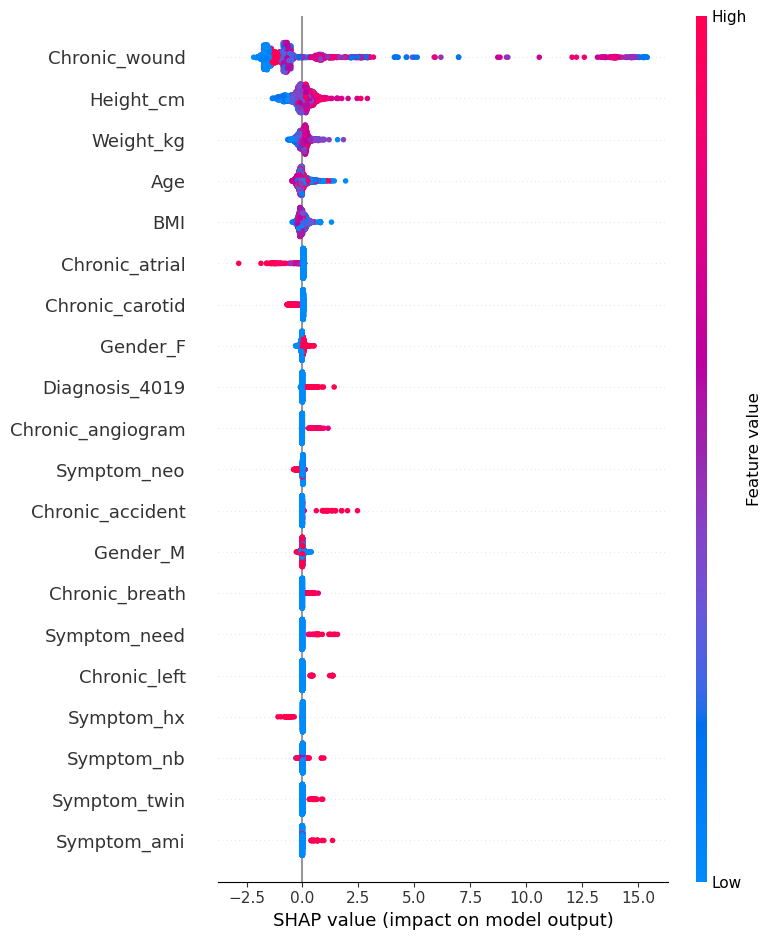

In [233]:
dt_model = OneVsRestClassifier(LGBMClassifier(random_state=42,subsample=1.0,n_estimators=100,max_depth=10,learning_rate=0.1,colsample_bytree=0.8))
dt_model.fit(X_train_final_df, y_train_df)

# Initialize SHAP Explainer and dictionary to store SHAP values for each model
shap_values_dict = {}

# Loop through each estimator (LightGBM model) in the OneVsRestClassifier
for i, estimator in enumerate(dt_model.estimators_):
   
    # Create SHAP explainer for each model
    explainer = shap.TreeExplainer(estimator)
    
    # Compute SHAP values for the training data
    shap_values = explainer.shap_values(X_train_final_df)
    
    # Store the SHAP values for this class
    shap_values_dict[i] = shap_values

# Example: plot SHAP values for the first class
shap.summary_plot(shap_values_dict[0], X_train_final_df)


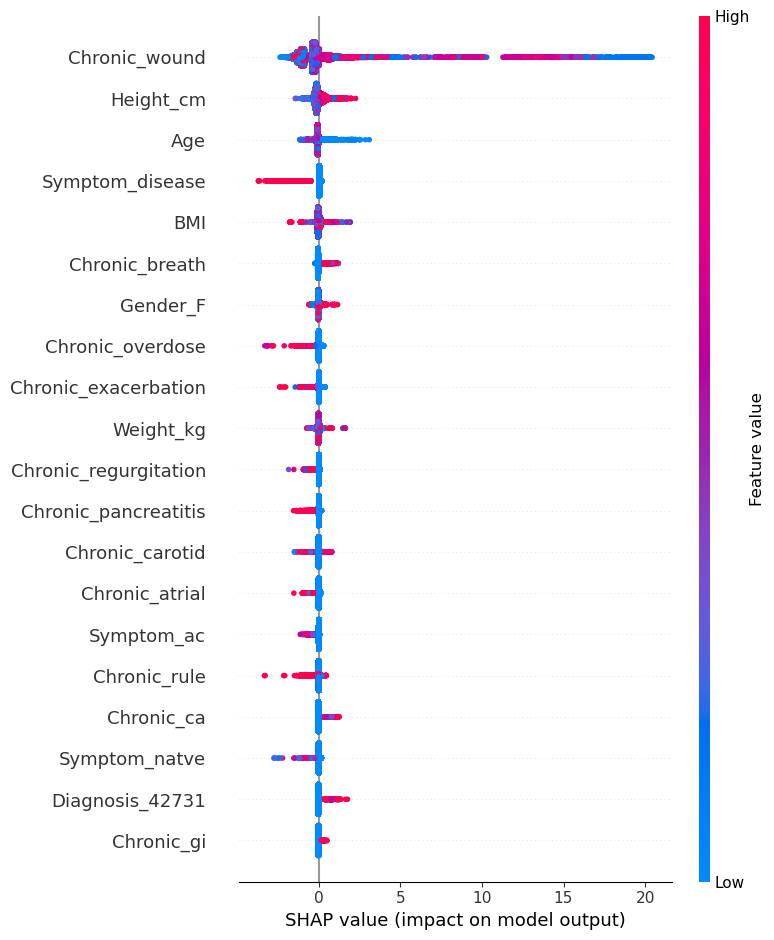

In [218]:

dt_model = OneVsRestClassifier(LGBMClassifier(random_state=42))
dt_model.fit(X_train_balanced, y_train_balanced)

# Initialize SHAP Explainer and dictionary to store SHAP values for each model
shap_values_dict = {}

# Loop through each estimator (LightGBM model) in the OneVsRestClassifier
for i, estimator in enumerate(dt_model.estimators_):
   
    # Create SHAP explainer for each model
    explainer = shap.TreeExplainer(estimator)
    
    # Compute SHAP values for the training data
    shap_values = explainer.shap_values(X_train_balanced)
    
    # Store the SHAP values for this class
    shap_values_dict[i] = shap_values

# Example: plot SHAP values for the first class
shap.summary_plot(shap_values_dict[0], X_train_balanced)


### Results and Takeaways

#### Model Selection:

LightGBM consistently outperformed other models like XGBoost, Random Forest, and Decision Tree on both training and test sets.

### Top Features for Predicting Medications for Each Label 
    * Red points - High feature value
    * Blue points - Low feature value
    * Horizontal spread shows impact of prediction
    * Summary of generic top features for each label
        - Chronic conditions(wound,carotid,atrial,regurgitation,exacerbation,pancreatitis)
        - Age
        - Gender
        - Weight
        - Diagnosis
        - Symptom
        - Height
### Conclusion

1. LightGBM is evaluated as the best model for this multi-label classification, recommended medication is predicted based on chronic condition, age,weight symptom,gender, specific diagnosis codes and height
2. SHAP visualization indicate important features per label
3. In a multi-label classification patients can receive multiple medications based on chronic conditions and other demographic features

### Future Work

1. Availability of more data will drive better predictability
2. Sentiment analysis of chronic condition and symptoms using Word2vec for better prediction
3. Proof of concept to integrate with EHR


In [220]:
# Save trained model and features
joblib.dump(dt_model, 'lgbm_model.pkl')
joblib.dump(feature_importance_dict, 'features.pkl')  # optional: save colum

['features.pkl']

In [ ]:
# import os

X_sample = X_train_balanced.sample(500, random_state=42)

# Directory to save plots
# os.makedirs("shap_summary_lightgbm", exist_ok=True)

# Loop through each label/class
for i, label in enumerate(y_train_balanced.columns):
    print(f"Explaining SHAP for: {label}")
    
    try:
        model_for_label = dt_model.estimators_[i]
        explainer = shap.Explainer(model_for_label, X_sample)
        shap_values = explainer(X_sample)

        # Save summary bar plot
        shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=20, show=False)
        plt.savefig(f"shap_summary_lightgbm/{label}_shap_summary.png", bbox_inches="tight")
        plt.close()
        print(f"Saved shap_summary_lightgbm/{label}_shap_summary.png")
        
    except Exception as e:
        print(f"Could not generate SHAP plot for {label}: {e}")
